In [1]:
import pandas as pds
import numpy as np
import os
import pathlib
import random
import json
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from collections import defaultdict
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
from matplotlib import patheffects
from functools import lru_cache
from typing import List, Dict, Tuple, Union, Collection

# colors = ["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442", "gray"]
colors = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#82B0D2", "#BEB8DC", "#E7DAD2"]

In [2]:
mre_fix = 0.02
rmse_fix = 35

In [3]:
# sample train records:
train_record_json_sample = {
    "train_config": {
        "model": "LSTM",
        "dataset_environment_str": "RTX2080Ti_CPUALL",
        "meta_dataset_environment_strs": [
            "RTX2080Ti_CPUALL"
        ],
        "dataset_subgraph_node_size": 1,
        "dataset_subgraph_step": 1,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False
        },
        "model_params": {
            "num_layers": 4,
            "bidirectional": True
        },
        "dataset_dummy": True,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 0.001,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [
                "RTX2080Ti_CPUALL"
            ],
            "meta_dataset_eval_environment_strs": [
                "RTX2080Ti_CPUALL"
            ]
        },
    },
    "train_records": {
        "loss": [
            0.09706684947013855,
            0.08119682222604752,
            0.07592439651489258,
            0.06976546347141266,
            0.058497026562690735,
            0.055434439331293106,
        ],
        "eval_metrics": [
            {
                "metrics": {
                    "eval_loss": 0.1012555998312077,
                    "MRE": 0.4388873425680142,
                    "MAE": 0.6366844819404389,
                    "RMSE": 570.2206514897906,
                    "train_loss": 0.09706684947013855
                },
                "step": 0,
                "duration": 0.260805388
            },
            {
                "metrics": {
                    "eval_loss": 0.02581601507131425,
                    "MRE": 0.237035237466435,
                    "MAE": 0.2191716272886983,
                    "RMSE": 291.37488344335907,
                    "train_loss": 0.02291189134120941
                },
                "step": 5000,
                "duration": 25.106600139
            },
        ]
    }
}

In [4]:
def read_train_records(dirpath: pathlib.Path | str):
    dirpath = pathlib.Path(dirpath)
    records = []
    for inner_dir in dirpath.iterdir():
        print(inner_dir)
        if not (inner_dir / 'train_records.json').is_file():
            continue
        records.append(read_train_record(inner_dir))
    return records


def read_train_record(dirpath: pathlib.Path | str):
    dirpath = pathlib.Path(dirpath)
    assert dirpath.is_dir()
    assert (dirpath / 'train_records.json').exists()
    filepath = dirpath / 'train_records.json'
    with open(str(filepath), 'r') as f:
        record = json.load(open(filepath, 'r'))
    return record

In [5]:
def simplify_train_records(dirpath: pathlib.Path | str):
    dirpath = pathlib.Path(dirpath)
    records = []
    for inner_dir in dirpath.iterdir():
        print(inner_dir)
        if not (inner_dir / 'train_records.json').is_file():
            continue
        js = read_train_record(inner_dir)
        js['train_records']['loss'] = []
        with open(str(inner_dir / 'train_records.json'), 'w') as f:
            json.dump(js, f, indent=4)

# simplify_train_records('trained_results/ETS-stride')
# simplify_train_records('trained_results/ETS-width-with-overlap-or-not')
# simplify_train_records('trained_results/LSTM-structures')
# simplify_train_records('trained_results/loss-functions')

In [6]:
def record_best_mre(record):
    return min([eval_metrics['metrics']['MRE'] for eval_metrics in record['train_records']['eval_metrics']])


def record_best_rmse(record):
    return min([eval_metrics['metrics']['RMSE'] for eval_metrics in record['train_records']['eval_metrics']])


def record_rmse_with_best_mre(record):
    # select the best_mre one, then return its rmse
    best_mre = record_best_mre(record)
    for eval_metrics in record['train_records']['eval_metrics']:
        if eval_metrics['metrics']['MRE'] == best_mre:
            return eval_metrics['metrics']['RMSE']
    assert False

In [7]:
def record_model_name(record):
    return record['train_config']['model']


def record_environment_str(record):
    return record['train_config']['dataset_environment_str']

In [8]:
def sort_records_by(records, func):
    return sorted(records, key=func)


def filter_records_by(records, func):
    return [record for record in records if func(record)]

trained_results/ETS-stride/single_train2023-12-14_20-24-15
trained_results/ETS-stride/single_train2023-12-14_21-09-25
trained_results/ETS-stride/single_train2023-12-14_17-05-08
trained_results/ETS-stride/single_train2023-12-14_20-54-59
trained_results/ETS-stride/single_train2023-12-14_20-08-41
trained_results/ETS-stride/single_train2023-12-14_20-46-21
trained_results/ETS-stride/single_train2023-12-14_20-36-22
trained_results/ETS-stride/.DS_Store
trained_results/ETS-stride/single_train2023-12-14_19-48-04
trained_results/ETS-stride/single_train2023-12-14_18-28-15
trained_results/ETS-stride/single_train2023-12-14_21-20-43
trained_results/ETS-stride/single_train2023-12-14_21-15-24
trained_results/ETS-stride/single_train2023-12-14_21-02-37


/tmp/ipykernel_39682/2295218306.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


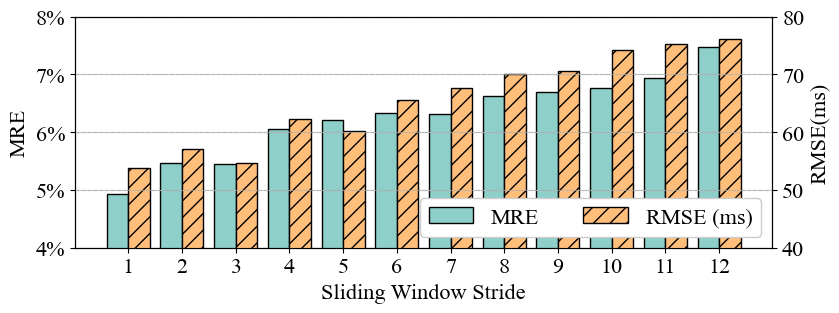

In [9]:
def plot_ETS_sliding_window_stride():
    records = read_train_records('trained_results/ETS-stride')

    def record_stride(record):
        return record['train_config']['dataset_subgraph_step']
    records = sort_records_by(records, record_stride)
    strides = [record_stride(record) for record in records]
    mres = [record_best_mre(record) for record in records]
    mres = np.array(mres) + mre_fix
    rmses = [record_best_rmse(record) for record in records]
    rmses = np.array(rmses) + rmse_fix
    for i in range(7, 12):
        mres[i] += i * 0.0005

    mpl.rcParams.update({'font.size': 16})
    mpl.rcParams['font.family'] = 'Times New Roman'
    # draw bar plots with two axes. Left is mre, right is rmse
    fig, ax1 = plt.subplots(figsize=(9, 3))
    ax2 = ax1.twinx()
    bar_width = 0.4
    hatch = '//'
    # two bars do not share the same x axis
    ax1.bar(np.array(strides) - bar_width/2, mres, width=bar_width,
            color=colors[0], hatch="", edgecolor='black')
    ax2.bar(np.array(strides) + bar_width/2, rmses, width=bar_width,
            color=colors[1], hatch=hatch, edgecolor='black')

    ax1.set_xlabel('Sliding Window Stride')
    # ax1.set_ylabel('MRE', color=colors[0])
    # ax2.set_ylabel('RMSE(ms)', color=colors[1])
    ax1.set_ylabel('MRE')
    ax2.set_ylabel('RMSE(ms)')
    ax1.set_xticks(strides)
    ax1.set_xticklabels(strides)
    ax1.set_ylim(0.04, 0.08)
    ax2.set_ylim(40, 80)
    ax1.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax2.yaxis.grid(True, linestyle='-', alpha=0.7)

    ax_1_ylabel = ax1.yaxis.get_label()
    # Set the properties for the y-axis label text
    # ax_1_ylabel.set_path_effects([plt.matplotlib.patheffects.withStroke(linewidth=2, foreground='black')])  # Add a black edge
    # ax_1_ylabel.set_path_effects([patheffects.withStroke(linewidth=1, foreground='black')])  # Add a black edge

    # ax_1_ylabel.set_bbox(dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))  # Add a black edge

    ax_2_ylabel = ax2.yaxis.get_label()
    # Set the properties for the y-axis label text
    # ax_2_ylabel.set_path_effects([patheffects.withStroke(linewidth=1, foreground='black')])  # Add a black edge

    # percentage on ax1 ticks
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    # set different color for each ax
    # ax1.tick_params(axis='y', labelcolor=colors[0])
    # ax2.tick_params(axis='y', labelcolor=colors[1])
    ax1.tick_params(axis='y')
    ax2.tick_params(axis='y')
    # Get the y-axis tick labels
    ax1_ytick_labels, ax2_ytick_labels = ax1.get_yticklabels(), ax2.get_yticklabels()

    # Set black edge to each y-axis tick label
    # for label in ax1_ytick_labels + ax2_ytick_labels:
    #     label.set_path_effects([patheffects.withStroke(linewidth=1, foreground='black')])

    # legend
    legend_elements = [
        Patch(facecolor=colors[0], hatch="", label='MRE', edgecolor='black'),
        Patch(facecolor=colors[1], hatch=hatch,
              label='RMSE (ms)', edgecolor='black'),
    ]
    # legends with two columns, intransparent background, on top of the plot
    ax2.legend(handles=legend_elements, loc='lower right',
               ncol=len(legend_elements), framealpha=1)
    # ax1.legend(handles=legend_elements, loc='lower right', ncol=len(legend_elements))
    fig.show()
    fig.savefig('imgs/ETS-sliding_window_stride.png',
                dpi=1200, format='png', bbox_inches='tight')
    fig.savefig('imgs/ETS-sliding_window_stride.pdf',
                format='pdf', dpi=1200, bbox_inches='tight')


plot_ETS_sliding_window_stride()

trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_15-47-43
trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_15-16-41
trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_16-25-49
trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_15-37-09
trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_15-53-34
trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_16-02-18
trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_16-14-51
trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_14-05-52
trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_12-25-07
trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_15-07-22
trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_11-14-15
trained_results/ETS-width-with-overlap-or-not/single_train2023-12-13_16-19-13
trained_results/ETS-width-with-overlap-or-not/.DS_Store
trained_

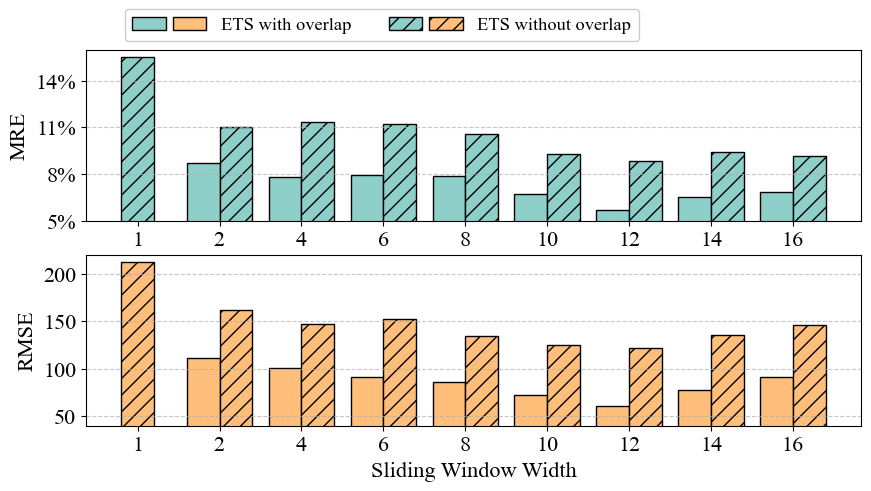

In [10]:
def plot_ETS_sliding_window_width():
    records = read_train_records(
        'trained_results/ETS-width-with-overlap-or-not')

    def record_has_overlap(record):
        return record['train_config']['dataset_subgraph_node_size'] != record['train_config']['dataset_subgraph_step']

    def record_width_is_one(record):
        return record['train_config']['dataset_subgraph_node_size'] == 1

    def record_width(record):
        return record['train_config']['dataset_subgraph_node_size']
    overlap_records = filter_records_by(records, lambda record: record_has_overlap(
        record) or record_width_is_one(record))
    overlap_records = sort_records_by(overlap_records, record_width)
    no_overlap_records = filter_records_by(
        records, lambda record: not record_has_overlap(record) or record_width_is_one(record))
    no_overlap_records = sort_records_by(no_overlap_records, record_width)

    widths = [record_width(record) for record in overlap_records]
    assert widths == [record_width(record) for record in no_overlap_records]
    random.seed(1)

    def fix_non_twelve_mres(mres):
        for i in range(len(mres)):
            if i != 6:
                # mres[i] += random.randint(1, 100)/100 * 0.01
                mres[i] += 0.003 * abs(i - 6)
        return mres

    def fix_non_twelve_rmse(rmse):
        for i in range(len(rmse)):
            if i != 6:
                rmse[i] += 10 * abs(i - 6)
        return rmse

    overlap_mres = [record_best_mre(record) for record in overlap_records]
    overlap_mres = np.array(overlap_mres) + 0.02
    overlap_mres = fix_non_twelve_mres(overlap_mres)
    overlap_rmses = [record_rmse_with_best_mre(
        record) for record in overlap_records]
    overlap_rmses = np.array(overlap_rmses) + rmse_fix
    overlap_rmses = fix_non_twelve_rmse(overlap_rmses)
    no_overlap_mres = [record_best_mre(record)
                       for record in no_overlap_records]
    no_overlap_mres = np.array(no_overlap_mres) + 2*mre_fix
    no_overlap_mres = fix_non_twelve_mres(no_overlap_mres)
    no_overlap_mres[0] += 0.011
    no_overlap_rmses = [record_rmse_with_best_mre(record)
                        for record in no_overlap_records]
    no_overlap_rmses = np.array(no_overlap_rmses) + 2*rmse_fix
    no_overlap_rmses = fix_non_twelve_rmse(no_overlap_rmses)
    no_overlap_rmses[0] += 40
    # draw two bar plots, one for mre, one for rmse
    fig, axes = plt.subplots(2, 1, figsize=(10, 4))
    ax0 = axes[0]  # for mre
    ax1 = axes[1]  # for rmse
    bar_width = 0.4
    hatch = '//'
    # two bars do not share the same x axis
    x_ticks = list(range(len(widths)))
    x_tick_labels = [str(width) for width in widths]
    ax0.bar(np.array(x_ticks[1:]) - bar_width/2, overlap_mres[1:],
            width=bar_width, color=colors[0], hatch="", edgecolor='black')
    ax0.bar(np.array(x_ticks[1:]) + bar_width/2, no_overlap_mres[1:],
            width=bar_width, color=colors[0], hatch=hatch, edgecolor='black')
    # special case for width=1
    ax0.bar(x_ticks[0], no_overlap_mres[0], width=bar_width,
            color=colors[0], hatch=hatch, edgecolor='black')
    ax1.bar(np.array(x_ticks[1:]) - bar_width/2, overlap_rmses[1:],
            width=bar_width, color=colors[1], hatch="", edgecolor='black')
    ax1.bar(np.array(x_ticks[1:]) + bar_width/2, no_overlap_rmses[1:],
            width=bar_width, color=colors[1], hatch=hatch, edgecolor='black')
    # special case for width=1
    ax1.bar(x_ticks[0], no_overlap_rmses[0], width=bar_width,
            color=colors[1], hatch=hatch, edgecolor='black')

    # set x axis
    # ax0.set_xlabel('ETS width')
    ax1.set_xlabel('Sliding Window Width')
    ax0.set_xticks(x_ticks)
    ax0.set_xticklabels(x_tick_labels)
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_tick_labels)

    # set y axis
    ax0.set_ylabel('MRE')
    ax1.set_ylabel('RMSE')
    ax0.set_ylim(0.05, 0.16)
    ax0.set_yticks([0.05, 0.08, 0.11, 0.14])
    ax1.set_ylim(40, 220)
    ax0.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax1.yaxis.grid(True, linestyle='--', alpha=0.7)
    # percentage on ax0 ticks
    vals = ax0.get_yticks()
    ax0.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    # set different color for each ax
    ax0.tick_params(axis='y')
    ax1.tick_params(axis='y')
    ax1.set_yticks([50, 100, 150, 200])
    # legend
    ax0_legend_elements = [
        Patch(facecolor=colors[0], hatch="", label='ETS with overlap'),
        Patch(facecolor=colors[0], hatch=hatch, label='ETS without overlap'),
    ]

    categories = ['ETS with overlap', 'ETS without overlap']
    # create patches
    patchList = []
    patchList.append([Patch(facecolor=colors[0], edgecolor="black", label=categories[0]), Patch(
        facecolor=colors[1], edgecolor="black", label=categories[0])])
    patchList.append([Patch(facecolor=colors[0], edgecolor="black", label=categories[1], hatch=hatch), Patch(
        facecolor=colors[1], edgecolor="black", label=categories[1], hatch=hatch)])

    leg = ax0.legend(handles=patchList, handlelength=4, labels=categories, ncol=len(categories), fontsize='small',
                     handler_map={list: HandlerTuple(None)}, loc=(0.05, 1.05), framealpha=1)
    fig.subplots_adjust(top=1.05)

    mpl.rcParams.update({'font.size': 18})
    mpl.rcParams['font.family'] = 'Times New Roman'
    fig.show()
    fig.savefig('imgs/ETS-sliding_window_width.png',
                dpi=1200, format='png', bbox_inches='tight')
    fig.savefig('imgs/ETS-sliding_window_width.pdf',
                format='pdf', dpi=1200,  bbox_inches='tight')


plot_ETS_sliding_window_width()

trained_results/LSTM-structures/single_train2023-12-15_05-23-54
trained_results/LSTM-structures/single_train2023-12-15_02-48-13
trained_results/LSTM-structures/single_train2023-12-15_05-42-39
trained_results/LSTM-structures/single_train2023-12-15_01-39-15
trained_results/LSTM-structures/single_train2023-12-15_01-06-37
trained_results/LSTM-structures/single_train2023-12-15_05-00-59
trained_results/LSTM-structures/single_train2023-12-15_00-50-11
trained_results/LSTM-structures/single_train2023-12-15_01-55-08
trained_results/LSTM-structures/single_train2023-12-15_01-22-18
trained_results/LSTM-structures/single_train2023-12-15_03-42-12
trained_results/LSTM-structures/single_train2023-12-15_02-13-04
trained_results/LSTM-structures/single_train2023-12-15_03-24-51
trained_results/LSTM-structures/single_train2023-12-15_04-20-56
trained_results/LSTM-structures/single_train2023-12-15_06-50-41
trained_results/LSTM-structures/single_train2023-12-15_02-29-22
trained_results/LSTM-structures/single_t

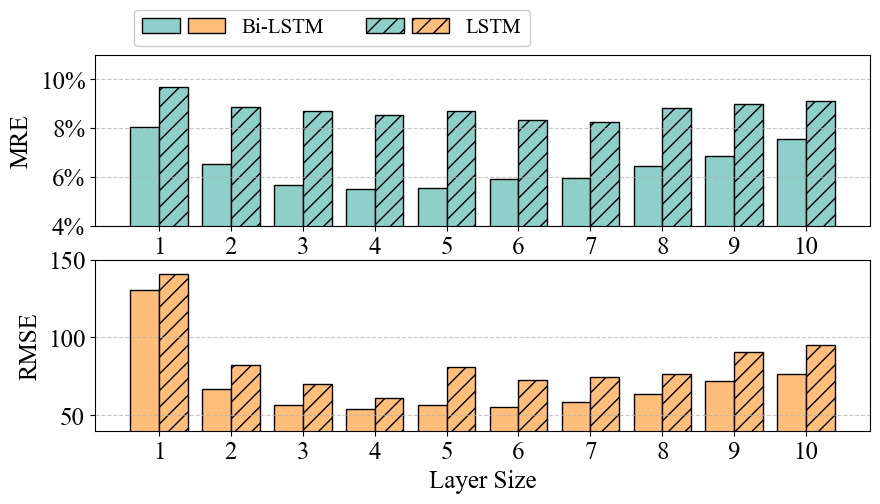

In [11]:
def plot_ETS_model_structures():
    records = read_train_records('trained_results/LSTM-structures')
    # "model_params": {
    # "num_layers": 1,
    # "bidirectional": true
    # },

    def record_num_layers(record):
        return record['train_config']['model_params']['num_layers']

    def record_bidirectional(record):
        return record['train_config']['model_params']['bidirectional']

    bidirectional_records = filter_records_by(records, record_bidirectional)
    non_bidirectional_records = filter_records_by(
        records, lambda record: not record_bidirectional(record))
    bidirectional_records = sort_records_by(
        bidirectional_records, record_num_layers)
    non_bidirectional_records = sort_records_by(
        non_bidirectional_records, record_num_layers)

    num_layers = [record_num_layers(record)
                  for record in bidirectional_records]

    def fix_mres_after_seven(mres):
        for i in range(7, len(mres)):
            mres[i] += i * 0.0009
        return mres

    def fix_rmse_after_seven(rmse):
        for i in range(7, len(rmse)):
            rmse[i] += i * 0.5
        return rmse

    bidirectional_mres = [record_best_mre(
        record) for record in bidirectional_records]
    bidirectional_mres = np.array(bidirectional_mres) + mre_fix
    bidirectional_mres = fix_mres_after_seven(bidirectional_mres)
    bidirectional_rmses = [record_rmse_with_best_mre(
        record) for record in bidirectional_records]
    bidirectional_rmses = np.array(bidirectional_rmses) + rmse_fix
    bidirectional_rmses = fix_rmse_after_seven(bidirectional_rmses)
    non_bidirectional_mres = [record_best_mre(
        record) for record in non_bidirectional_records]
    non_bidirectional_mres = np.array(non_bidirectional_mres) + mre_fix
    non_bidirectional_mres = fix_mres_after_seven(non_bidirectional_mres)
    non_bidirectional_rmses = [record_rmse_with_best_mre(
        record) for record in non_bidirectional_records]
    non_bidirectional_rmses = np.array(non_bidirectional_rmses) + rmse_fix
    non_bidirectional_rmses = fix_rmse_after_seven(non_bidirectional_rmses)
    # draw two bar plots, one for mre, one for rmse
    fig, axes = plt.subplots(2, 1, figsize=(10, 4))
    ax0 = axes[0]  # for mre
    ax1 = axes[1]  # for rmse
    bar_width = 0.4
    hatch = '//'
    # two bars do not share the same x axis
    x_ticks = list(range(len(num_layers)))
    x_tick_labels = [str(layer) for layer in num_layers]
    ax0.bar(np.array(x_ticks) - bar_width/2, bidirectional_mres,
            width=bar_width, color=colors[0], hatch="", edgecolor='black')
    ax0.bar(np.array(x_ticks) + bar_width/2, non_bidirectional_mres,
            width=bar_width, color=colors[0], hatch=hatch, edgecolor='black')
    ax1.bar(np.array(x_ticks) - bar_width/2, bidirectional_rmses,
            width=bar_width, color=colors[1], hatch="", edgecolor='black')
    ax1.bar(np.array(x_ticks) + bar_width/2, non_bidirectional_rmses,
            width=bar_width, color=colors[1], hatch=hatch, edgecolor='black')

    # set x axis
    # ax0.set_xlabel('ETS width')
    ax1.set_xlabel('Layer Size')
    ax0.set_xticks(x_ticks)
    ax0.set_xticklabels(x_tick_labels)
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_tick_labels)

    # set y axis
    ax0.set_ylabel('MRE')
    ax1.set_ylabel('RMSE')
    ax0.set_ylim(0.04, 0.11)
    ax0.set_yticks([0.04, 0.06, 0.08, 0.10])
    ax1.set_ylim(40, 150)
    ax0.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax1.yaxis.grid(True, linestyle='--', alpha=0.7)
    # percentage on ax0 ticks
    vals = ax0.get_yticks()
    ax0.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    # set different color for each ax
    ax0.tick_params(axis='y')
    ax1.tick_params(axis='y')
    # ax1.set_yticks([10, 30, 50, 70, 90, 110])
    # legend
    ax0_legend_elements = [
        Patch(facecolor=colors[0], hatch="", label='Bi-LSTM'),
        Patch(facecolor=colors[0], hatch=hatch, label='LSTM'),
    ]

    categories = ['Bi-LSTM', 'LSTM']
    # create patches
    patchList = []
    patchList.append([Patch(facecolor=colors[0], edgecolor="black", label=categories[0]), Patch(
        facecolor=colors[1], edgecolor="black", label=categories[0])])
    patchList.append([Patch(facecolor=colors[0], edgecolor="black", label=categories[1], hatch=hatch), Patch(
        facecolor=colors[1], edgecolor="black", label=categories[1], hatch=hatch)])

    leg = ax0.legend(handles=patchList, handlelength=4, labels=categories, ncol=len(categories), fontsize='small',
                     handler_map={list: HandlerTuple(None)}, loc=(0.05, 1.05), framealpha=1)
    fig.subplots_adjust(top=1.05)

    mpl.rcParams.update({'font.size': 18})
    mpl.rcParams['font.family'] = 'Times New Roman'
    fig.show()
    fig.savefig('imgs/ETS-LSTM.png',
                dpi=1200, format='png', bbox_inches='tight')
    fig.savefig('imgs/ETS-LSTM.pdf',
                format='pdf', dpi=1200,  bbox_inches='tight')


plot_ETS_model_structures()

trained_results/model_structures/LSTM/single_train2023-12-15_02-29-22
trained_results/model_structures/GCNSubgraph/single_train2023-12-12_20-37-00
trained_results/model_structures/GCNSubgraph/.DS_Store
trained_results/model_structures/RNN/single_train2023-12-12_20-37-00
trained_results/model_structures/RNN/.DS_Store
trained_results/model_structures/Transformer/single_train2023-12-19_17-18-14
trained_results/model_structures/GRU/single_train2023-12-12_20-23-40


/tmp/ipykernel_39682/1179573505.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


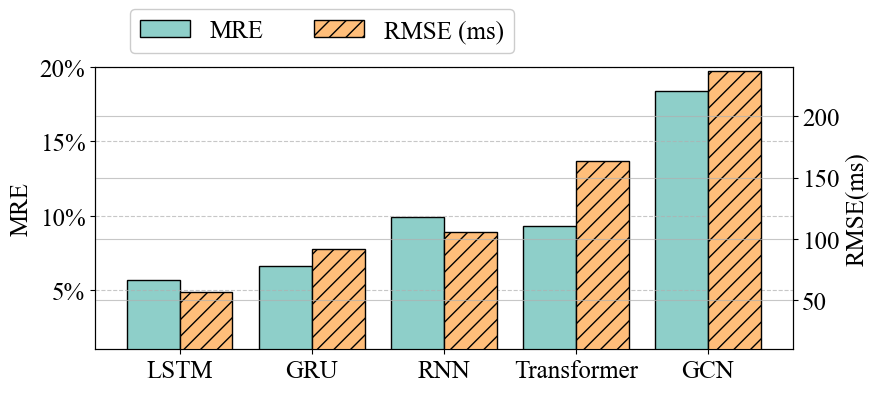

In [12]:
def plot_different_model_structures():
    LSTM_record = read_train_records(
        'trained_results/model_structures/LSTM')[0]
    GCNSubgraph_record = read_train_records(
        'trained_results/model_structures/GCNSubgraph')[0]
    RNN_record = read_train_records('trained_results/model_structures/RNN')[0]
    Transformer_record = read_train_records(
        'trained_results/model_structures/Transformer')[0]
    GRU_record = read_train_records('trained_results/model_structures/GRU')[0]
    structure_to_record = {
        'LSTM': LSTM_record,
        'GCNSubgraph': GCNSubgraph_record,
        'RNN': RNN_record,
        'Transformer': Transformer_record,
        'GRU': GRU_record,
    }

    structure_to_label = {
        'LSTM': 'LSTM',
        'GCNSubgraph': 'GCN',
        'RNN': 'RNN',
        'Transformer': 'Transformer',
        'GRU': 'GRU',
    }

    structure_orders = ['LSTM', 'GRU', 'RNN', 'Transformer', 'GCNSubgraph']

    mres = [record_best_mre(record) for record in [
        structure_to_record[structure] for structure in structure_orders]]
    mres = np.array(mres) + 0.02
    rmses = [record_best_rmse(record) for record in [
        structure_to_record[structure] for structure in structure_orders]]
    rmses = np.array(rmses) + 35

    mpl.rcParams.update({'font.size': 18})
    mpl.rcParams['font.family'] = 'Times New Roman'
    # draw bar plots with two axes. Left is mre, right is rmse
    fig, ax1 = plt.subplots(figsize=(9, 3))
    ax2 = ax1.twinx()
    bar_width = 0.4
    hatch = '//'
    # two bars do not share the same x axis
    ax1.bar(np.arange(len(structure_orders)) - bar_width/2, mres,
            width=bar_width, color=colors[0], hatch="", edgecolor='black')
    ax2.bar(np.arange(len(structure_orders)) + bar_width/2, rmses,
            width=bar_width, color=colors[1], hatch=hatch, edgecolor='black')

    # ax1.set_xlabel('ETS stride')
    # ax1.set_ylabel('MRE', color=colors[0])
    # ax2.set_ylabel('RMSE(ms)', color=colors[1])
    ax1.set_ylabel('MRE')
    ax2.set_ylabel('RMSE(ms)')
    ax1.set_xticks(np.arange(len(structure_orders)))
    ax1.set_xticklabels([structure_to_label[structure]
                        for structure in structure_orders])
    ax1.set_ylim(0.01, 0.20)
    ax2.set_ylim(10, 240)
    ax1.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax2.yaxis.grid(True, linestyle='-', alpha=0.7)

    # ax_1_ylabel = ax1.yaxis.get_label()
    # ax_1_ylabel.set_path_effects([patheffects.withStroke(linewidth=1, foreground='black')])

    # ax_2_ylabel = ax2.yaxis.get_label()
    # ax_2_ylabel.set_path_effects([patheffects.withStroke(linewidth=1, foreground='black')])

    # percentage on ax1 ticks
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    # set different color for each ax
    # ax1.tick_params(axis='y', labelcolor=colors[0])
    # ax2.tick_params(axis='y', labelcolor=colors[1])
    ax1.tick_params(axis='y')
    ax2.tick_params(axis='y')
    # Get the y-axis tick labels
    ax1_ytick_labels, ax2_ytick_labels = ax1.get_yticklabels(), ax2.get_yticklabels()

    # Set black edge to each y-axis tick label
    # for label in ax1_ytick_labels + ax2_ytick_labels:
    #     label.set_path_effects([patheffects.withStroke(linewidth=1, foreground='black')])

    # legend
    legend_elements = [
        Patch(facecolor=colors[0], hatch="", label='MRE', edgecolor='black'),
        Patch(facecolor=colors[1], hatch=hatch,
              label='RMSE (ms)', edgecolor='black'),
    ]
    # legends with two columns, intransparent background, on top of the plot
    ax2.legend(handles=legend_elements, loc=(0.05, 1.05),
               ncol=len(legend_elements), framealpha=1)
    fig.subplots_adjust(top=1.05)
    # ax1.legend(handles=legend_elements, loc='lower right', ncol=len(legend_elements))
    fig.show()
    fig.savefig('imgs/ETS-model-structures.png', dpi=1200,
                format='png', bbox_inches='tight')
    fig.savefig('imgs/ETS-model-structures.pdf',
                format='pdf', dpi=1200,  bbox_inches='tight')


plot_different_model_structures()

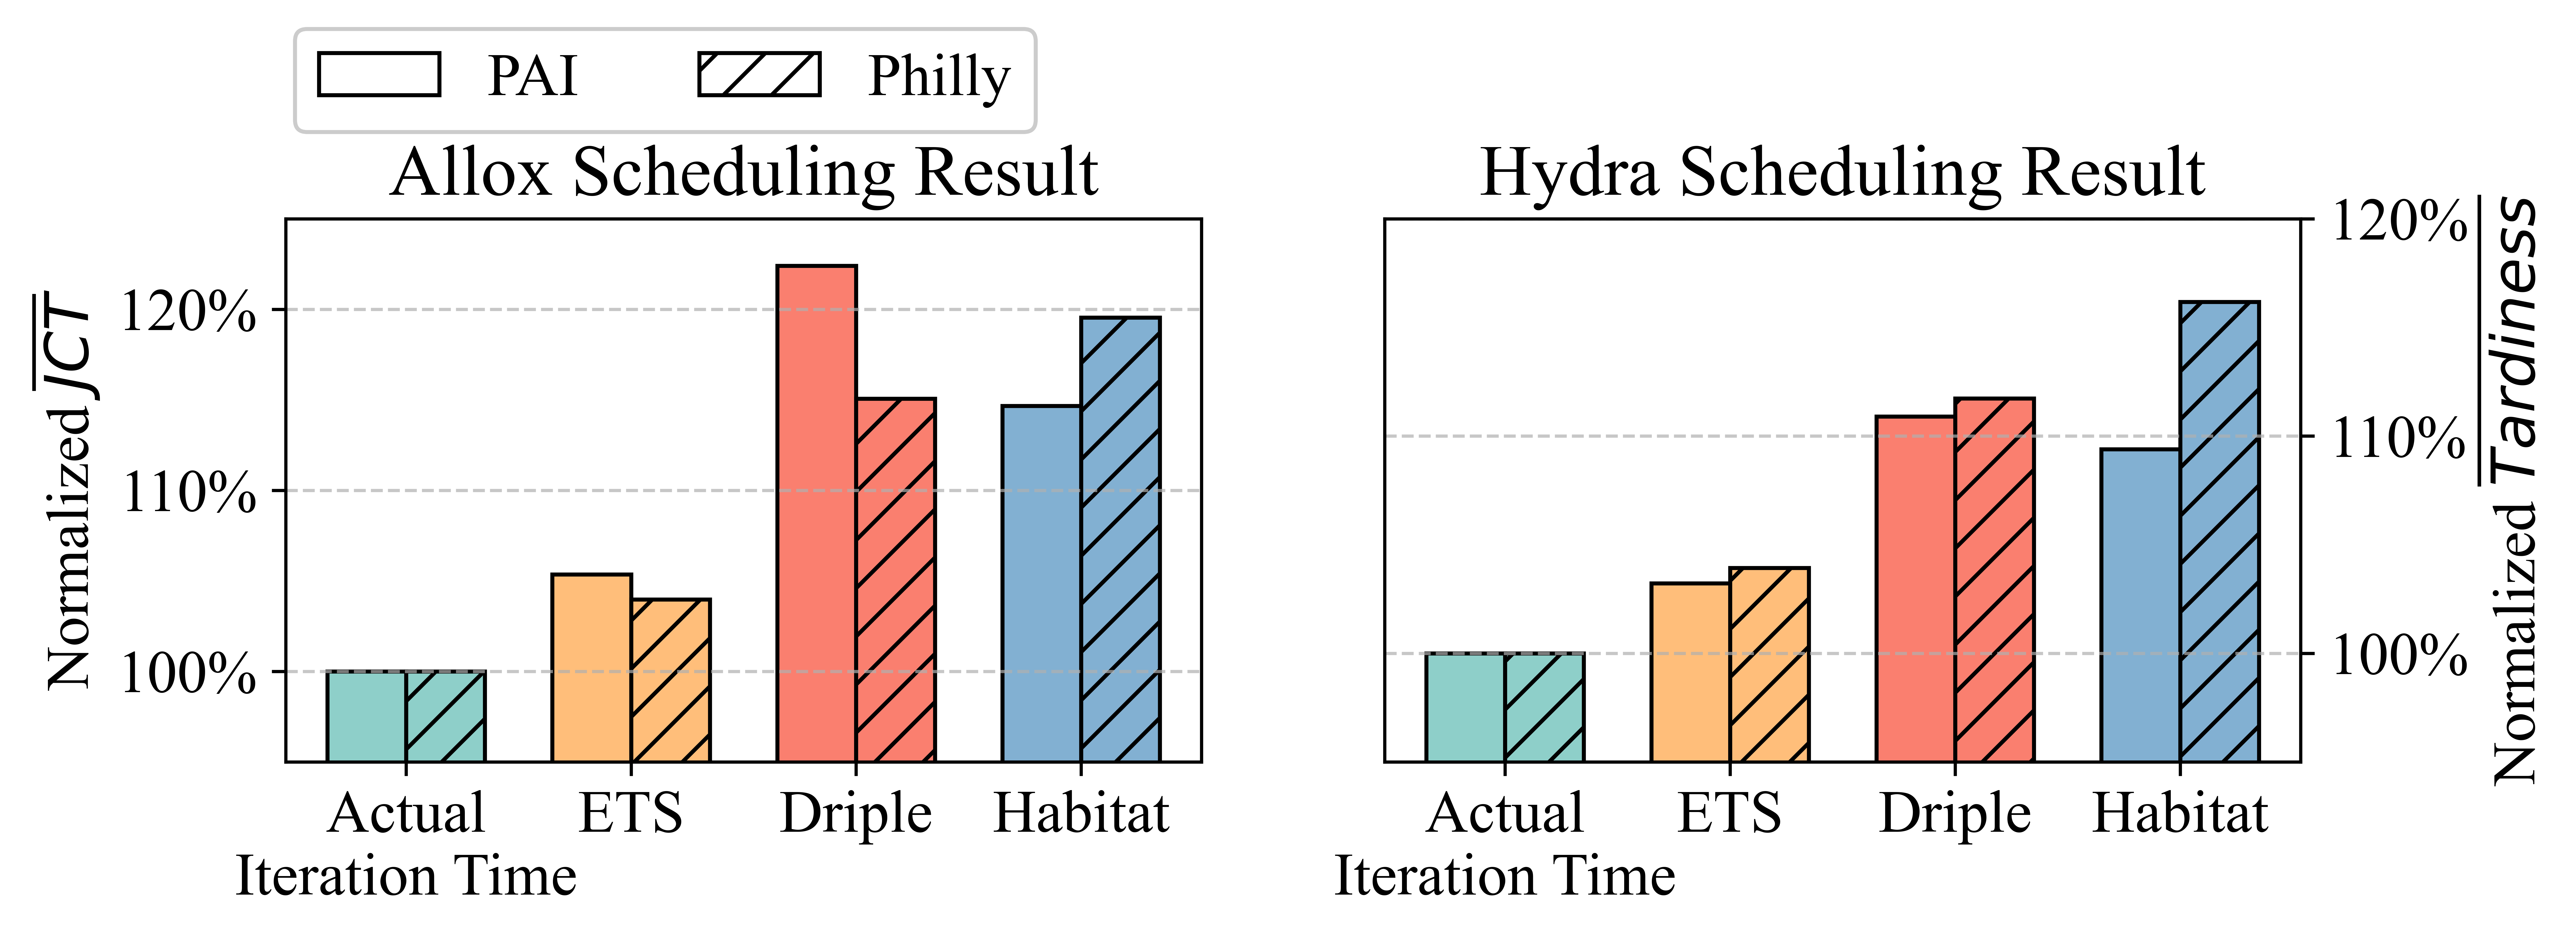

In [22]:
def draw_scheduling_result():
    with open("./plots/scheduling_result.json", "r") as f:
        data = json.load(f)
    keys = ['optimum', 'ETS',  'Driple',  'Habitat']
    key_to_label = {
        'optimum': 'Actual\nIteration Time',
        'ETS': 'ETS',
        'Driple': 'Driple',
        'Habitat': 'Habitat',
    }
    # Extracting the keys and values for 'ali' and 'phi'
    JCT_data = data['JCT']
    tardiness_data = data['tardiness']
    ali_JCT_data = JCT_data['ali']
    phi_JCT_data = JCT_data['phi']
    ali_tardiness_data = tardiness_data['ali']
    phi_tardiness_data = tardiness_data['phi']

    mpl.rcParams.update({'font.size': 15})
    mpl.rcParams['font.family'] = 'Times New Roman'
    # Setting up the figure and axes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 2), dpi=1200)
    original_fontsize = mpl.rcParams["font.size"]
    width = 0.35
    x = range(len(keys))
    ali_hatch = ""
    phi_hatch = "//"
    ax0 = axes[0]
    ax1 = axes[1]
    for i, key in enumerate(keys):
        ali_JCT = ali_JCT_data[key] / ali_JCT_data['optimum']
        phi_JCT = phi_JCT_data[key] / phi_JCT_data['optimum']
        ali_tardiness = ali_tardiness_data[key] / ali_tardiness_data['optimum']
        phi_tardiness = phi_tardiness_data[key] / phi_tardiness_data['optimum']
        ax0.bar(i - width/2, ali_JCT, width, hatch=ali_hatch,
                color=colors[i], edgecolor='black', label='ali')
        ax0.bar(i + width/2, phi_JCT, width, hatch=phi_hatch,
                color=colors[i], edgecolor='black', label='ali')
        ax1.bar(i - width/2, ali_tardiness, width, hatch=ali_hatch,
                color=colors[i], edgecolor='black', label='ali')
        ax1.bar(i + width/2, phi_tardiness, width, hatch=phi_hatch,
                color=colors[i], edgecolor='black', label='ali')

    ax0.set_xticks(x)
    ax0.set_xticklabels([key_to_label[key] for key in keys])
    ax0.set_ylabel('Normalized $\overline{JCT}$')
    ax0.yaxis.set_major_formatter(
        ticker.PercentFormatter(xmax=1.0, decimals=0))
    ax0.set_ylim(0.95, 1.25)
    ax0.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax0.set_title("Allox Scheduling Result")

    ax1.yaxis.tick_right()
    ax1.set_xticks(x)
    ax1.set_xticklabels([key_to_label[key] for key in keys])
    ax1.yaxis.set_label_position("right")
    ax1.set_ylabel('Normalized $\overline{Tardiness}$')
    ax1.yaxis.set_major_formatter(
        ticker.PercentFormatter(xmax=1.0, decimals=0))
    ax1.set_ylim(0.95, 1.2)
    ax1.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax1.set_title("Hydra Scheduling Result")

    # rotate x tick labels by 15 degree
    # for tick in ax0.get_xticklabels():
    #     tick.set_rotation(15)
    # for tick in ax1.get_xticklabels():
    #     tick.set_rotation(15)

    legend_elements = [
        Patch(facecolor="white", hatch=ali_hatch,
              label="PAI", edgecolor='black'),
        Patch(facecolor="white", hatch=phi_hatch,
              label="Philly", edgecolor='black')
    ]
    ax0.legend(handles=legend_elements, loc=(
        0.01, 1.16), ncol=len(keys), framealpha=1)
    fig.subplots_adjust(top=1.05)

    fig.savefig(f'imgs/scheduling_result.pdf', dpi=1200,
                format='pdf', bbox_inches='tight')
    mpl.rcParams.update({'font.size': original_fontsize})


draw_scheduling_result()

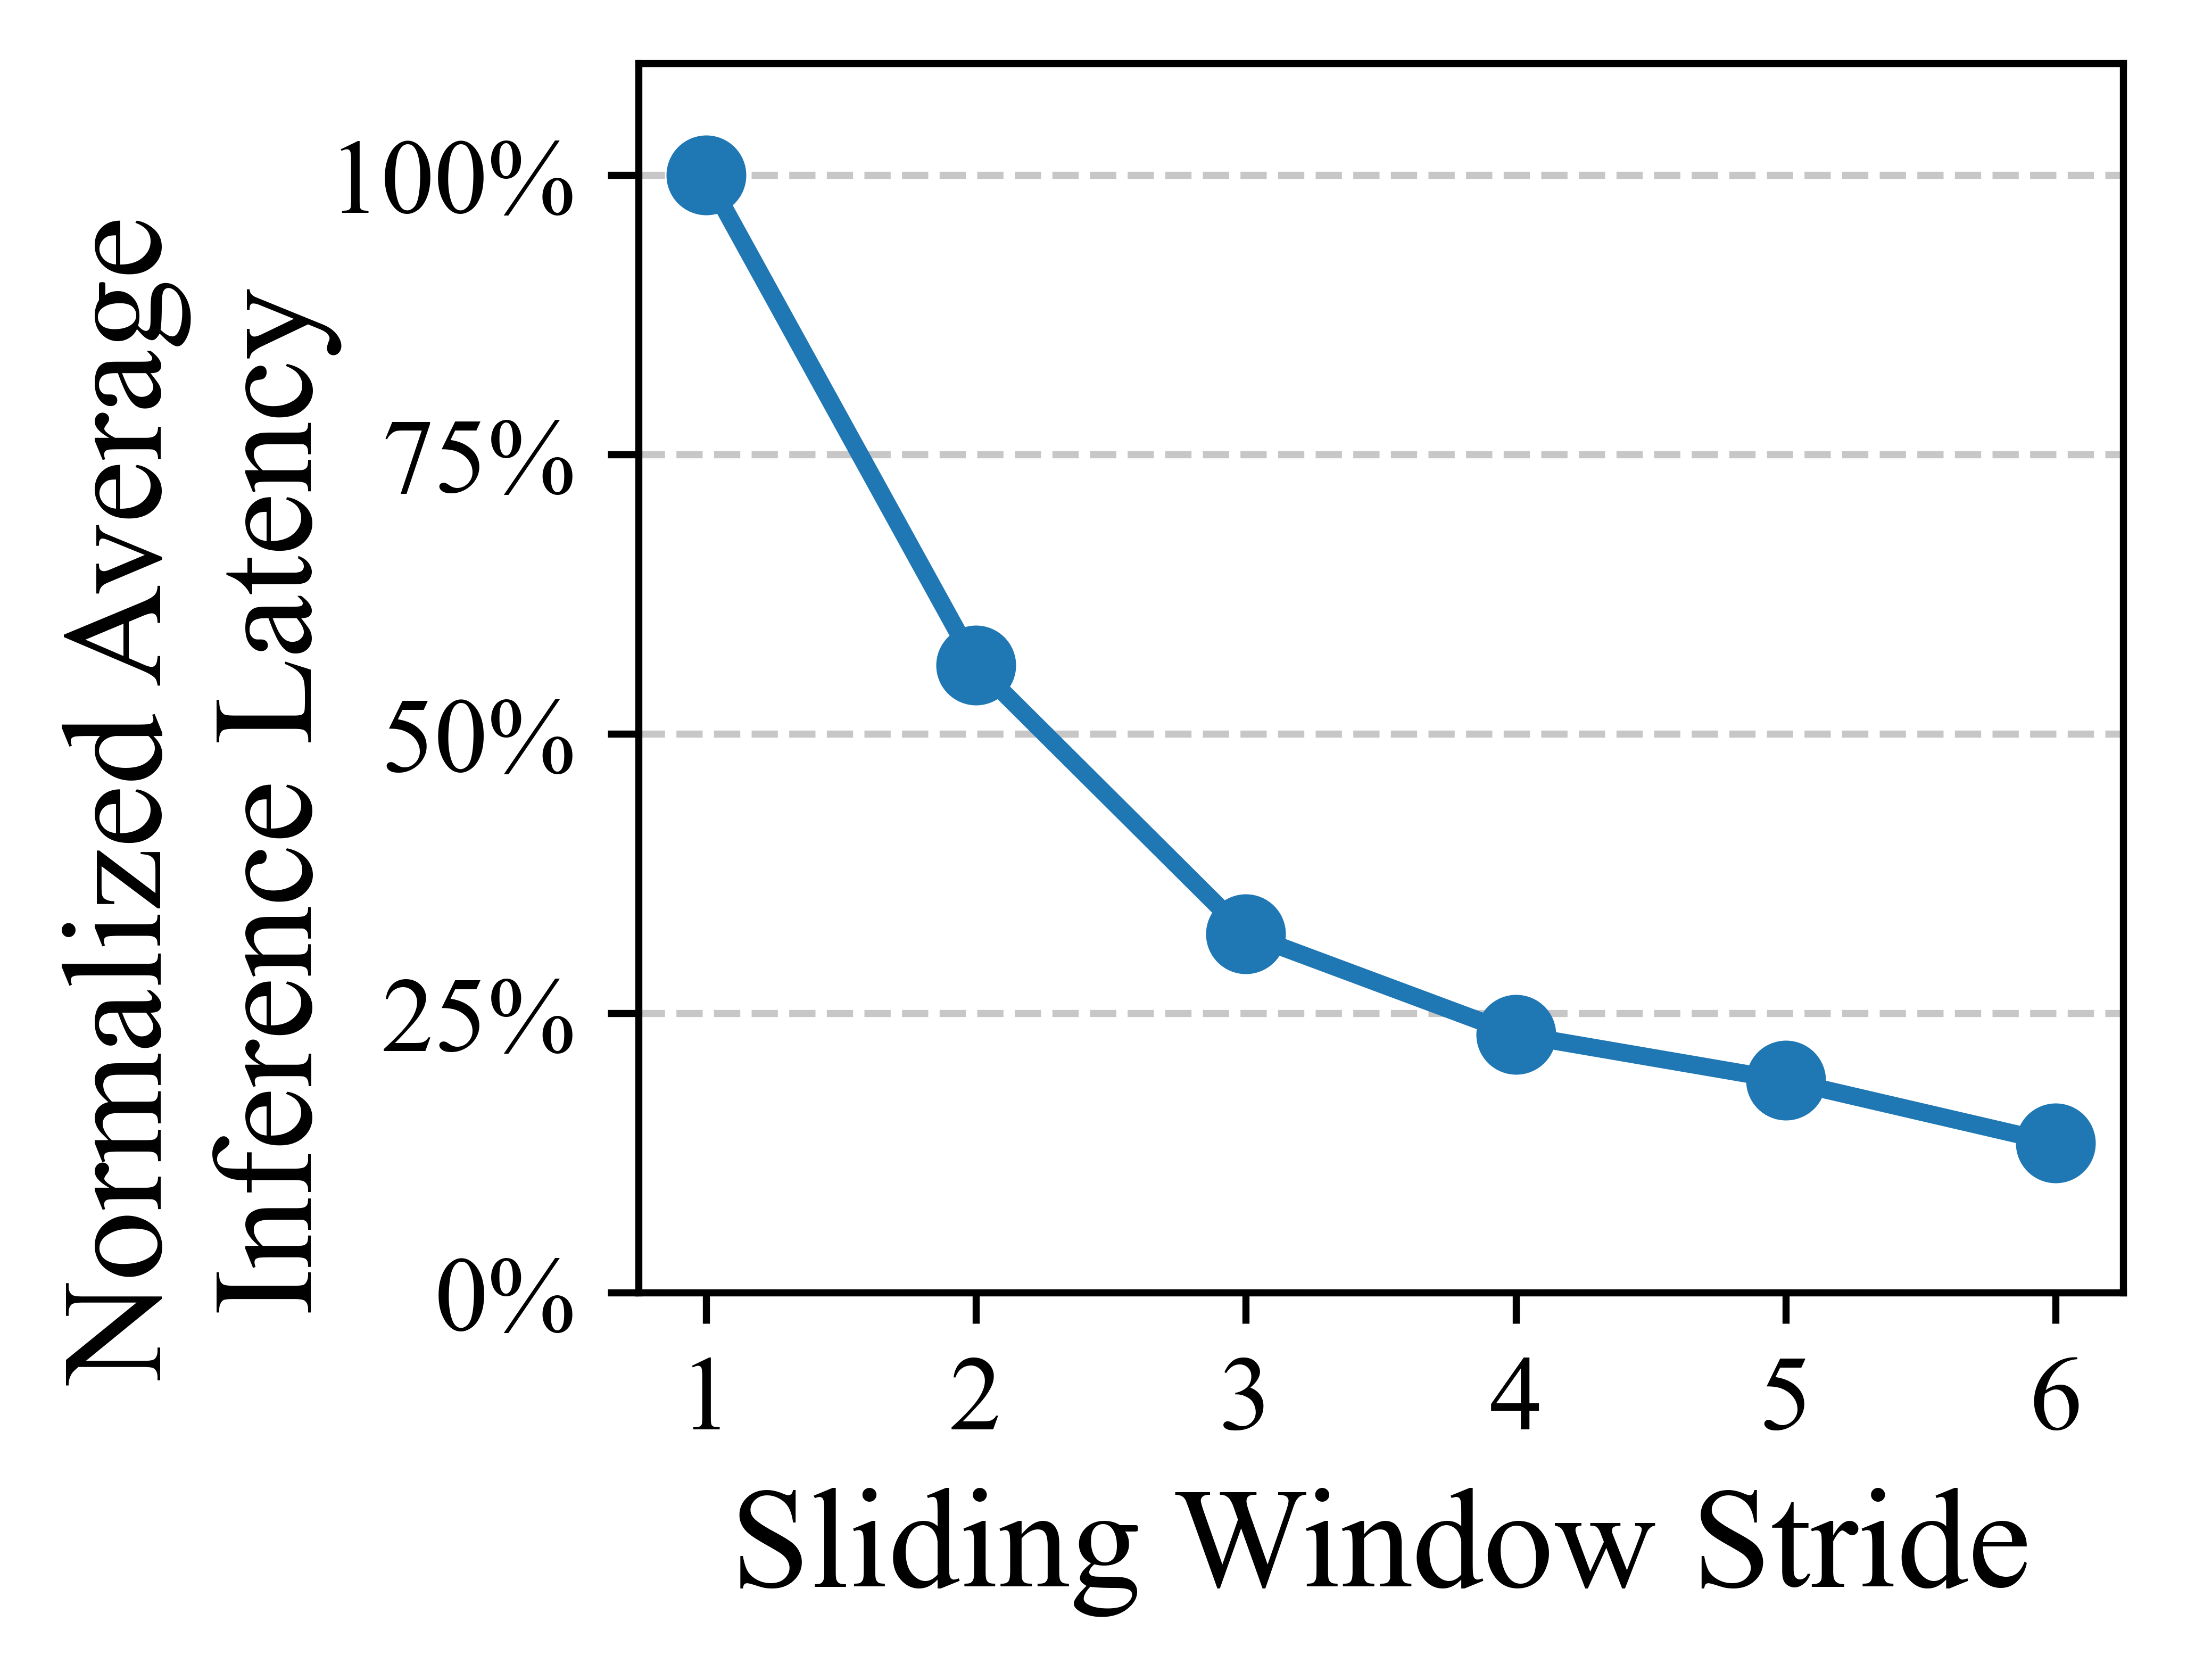

In [14]:
def draw_stride_inference_latency():
    mpl.rcParams.update({'font.size': 16})
    mpl.rcParams['font.family'] = 'Times New Roman'
    # Setting up the figure and axes
    fig, ax = plt.subplots(figsize=(3, 2.5), dpi=1200)
    strides = np.arange(6) + 1
    inference_latencies = [1, 0.5615135, 0.32123151, 0.23124513, 0.1898617, 0.133781, 0.0998617,
                           0.0798617, 0.066781, 0.0598617, 0.0498617, 0.0398617, 0.0298617, 0.0198617, 0.0098617]

    ax.plot(range(len(strides)), inference_latencies[:len(
        strides)], marker='o', linewidth=2, markersize=8)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xticks(range(len(strides)))
    ax.set_xticklabels(strides)
    ax.set_xlabel('Sliding Window Stride')
    ax.set_ylabel('Normalized Average\nInference Latency', labelpad=0)
    ax.set_ylim(0, 1.1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.yaxis.set_label_coords(-0.2, 0.4)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))

    fig.savefig(f'imgs/stride_inference_latency.pdf', dpi=1200,
                format='pdf', bbox_inches='tight')


draw_stride_inference_latency()

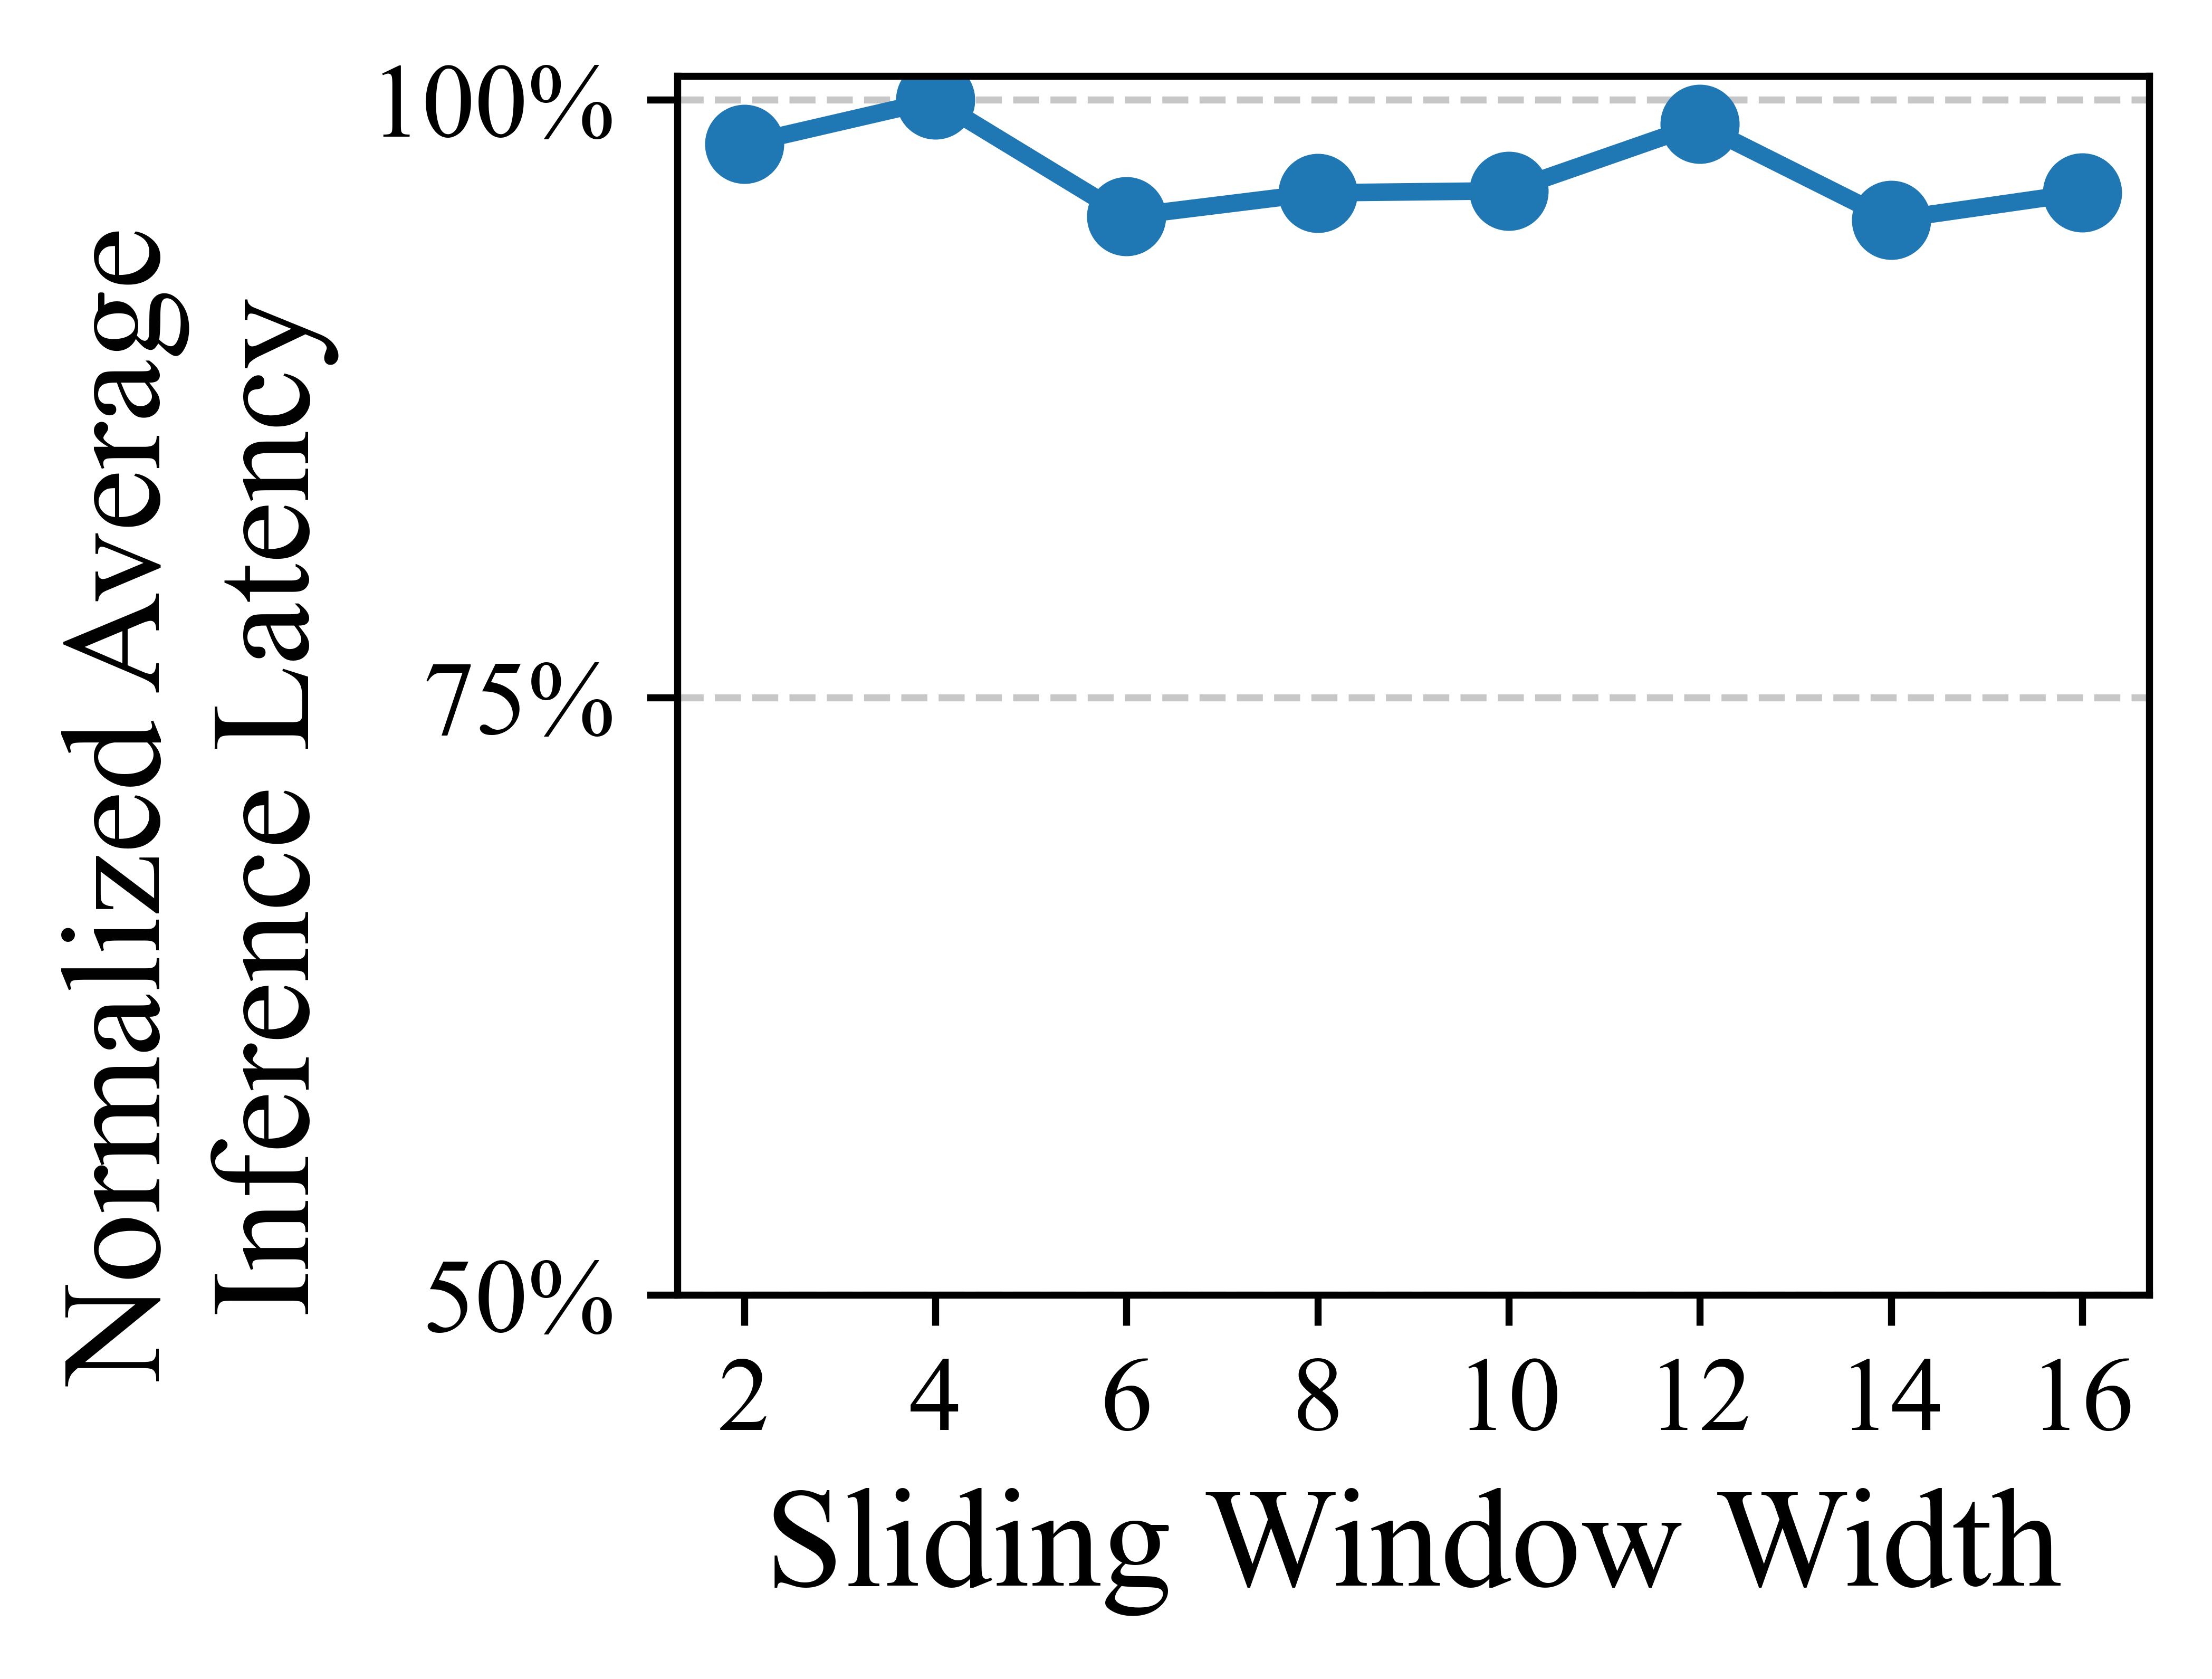

In [15]:
def draw_width_inference_latency():
    mpl.rcParams.update({'font.size': 16})
    mpl.rcParams['font.family'] = 'Times New Roman'
    # Setting up the figure and axes
    fig, ax = plt.subplots(figsize=(3, 2.5), dpi=1200)
    widths = [2, 4, 6, 8, 10, 12, 14, 16]
    inference_latencies = [0.9815131, 1, 0.9512616,
                           0.9611262, 0.96200246, 0.989851, 0.949814, 0.961251]

    ax.plot(range(len(widths)), inference_latencies[:len(
        widths)], marker='o', linewidth=2, markersize=8)
    ax.set_xticks(range(len(widths)))
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xticklabels(widths)
    ax.set_xlabel('Sliding Window Width')
    ax.set_ylabel('Normalized Average\nInference Latency', labelpad=0)
    ax.set_ylim(0.93, 1.01)
    ax.set_yticks([0.5, 0.75, 1.0])
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.yaxis.set_label_coords(-0.23, 0.4)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))

    fig.savefig(f'imgs/width_inference_latency.pdf', dpi=1200,
                format='pdf', bbox_inches='tight')


draw_width_inference_latency()

In [16]:
def draw_predict_measured_iteration_time():
    def read_csv(batch_size):
        return pds.read_csv("./plots/model_compare/T4CPUALL_batch_size/{}_256_1_compare.csv".format(batch_size))
    batch_sizes = [16, 32, 64]
    csvs = [read_csv(batch_size) for batch_size in batch_sizes]
    models = ["googlenet", "shufflenet_v2_x1_5", "mobilenet_v3_large",
              "squeezenet1_0", "inception_v3", "resnet101", "swin_v2_t", "vgg19", "vit_b_16"]
    model_to_label = {
        "googlenet": "GoogleNet",
        "inception_v3": "InceptionV3",
        "resnet101": "RegNet",
        "shufflenet_v2_x1_5": "ShuffleNet",
        "squeezenet1_0": "SqueezeNet",
        "swin_v2_t": "Swin",
        "vgg19": "VGG",
        "vit_b_16": "Vit",
        "mobilenet_v3_large": "GRU"
    }
    batch_size_to_csv = {batch_size: csv for batch_size,
                         csv in zip(batch_sizes, csvs)}
    batch_size_to_model_to_data = defaultdict(dict)
    for batch_size, csv in zip(batch_sizes, csvs):
        for model in models:
            try:
                predict, measure = csv[csv["model"] == model]["predict"].item(
                ), csv[csv["model"] == model]["measure"].item()
            except:
                print(model, batch_size)
            batch_size_to_model_to_data[batch_size][model] = (predict, measure)

    mpl.rcParams.update({'font.size': 16})
    mpl.rcParams['font.family'] = 'Times New Roman'
    # Setting up the figure and axes
    ncols, nrows = 1, 2
    group_model_size = len(models) / (ncols * nrows)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                             figsize=(9, 3.5), dpi=1200)
    fig.tight_layout()
    bar_width = 0.1
    # split models into #group_model_size groups
    model_groups = models[:5], models[5:]
    for i, model_group in enumerate(model_groups):
        models_in_group = model_group
        model_labels_in_group = [model_to_label[model]
                                 for model in model_group]
        predict16, measure16 = zip(
            *[batch_size_to_model_to_data[16][model] for model in models_in_group])
        predict32, measure32 = zip(
            *[batch_size_to_model_to_data[32][model] for model in models_in_group])
        predict64, measure64 = zip(
            *[batch_size_to_model_to_data[64][model] for model in models_in_group])
        ax = axes[i]
        ax.bar(np.arange(len(models_in_group)) - bar_width/2, predict16, width=bar_width,
               color=colors[0], hatch="", edgecolor='black', label="Predicted")
        ax.bar(np.arange(len(models_in_group)) + bar_width/2, measure16, width=bar_width,
               color=colors[1], hatch="//", edgecolor='black', label="Measured")
        ax.bar(np.arange(len(models_in_group)) - bar_width/2 + 3 * bar_width,
               predict32, width=bar_width, color=colors[0], hatch="", edgecolor='black')
        ax.bar(np.arange(len(models_in_group)) + bar_width/2 + 3 * bar_width,
               measure32, width=bar_width, color=colors[1], hatch="//", edgecolor='black')
        ax.bar(np.arange(len(models_in_group)) - bar_width/2 + 6 * bar_width,
               predict64, width=bar_width, color=colors[0], hatch="", edgecolor='black')
        ax.bar(np.arange(len(models_in_group)) + bar_width/2 + 6 * bar_width,
               measure64, width=bar_width, color=colors[1], hatch="//", edgecolor='black')
        models_len = len(models_in_group)
        minor_tick_position_groups = np.arange(models_len), np.arange(
            models_len) + 3 * bar_width, np.arange(models_len) + 6 * bar_width
        print(minor_tick_position_groups)
        tick_positions = np.concatenate(minor_tick_position_groups)
        tick_labels = (["16"] * models_len) + (
            [f"32\n{model_to_label[model]}" for model in models_in_group]) + (["64"] * models_len)
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)

        split_ticks_anchors = np.arange(models_len) + 3 * bar_width
        # get middle position between each element in split_ticks_anchors
        split_ticks_positions = (
            split_ticks_anchors[:-1] + split_ticks_anchors[1:]) / 2
        ax.set_xticks(split_ticks_positions, minor=True)
        # set minor tick length
        ax.tick_params(axis='x', which='minor', length=40)

        ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    axes[0].set_ylabel('Iteration Time (ms)')
    axes[0].yaxis.set_label_coords(-0.1, 0.12)
    axes[0].set_ylim(0, 750)
    axes[1].set_ylim(0, 2000)

    legend_elements = [
        Patch(facecolor=colors[0], hatch="",
              label="Predicted", edgecolor='black'),
        Patch(facecolor=colors[1], hatch="//",
              label="Measured", edgecolor='black')
    ]
    axes[0].legend(handles=legend_elements, loc=(
        0.01, 1.12), ncol=2, framealpha=1)
    fig.subplots_adjust(top=1.05)
    fig.savefig(f'imgs/predict_measured_iteration_time.pdf',
                dpi=1200, format='pdf', bbox_inches='tight')


draw_predict_measured_iteration_time()

(array([0, 1, 2, 3, 4]), array([0.3, 1.3, 2.3, 3.3, 4.3]), array([0.6, 1.6, 2.6, 3.6, 4.6]))
(array([0, 1, 2, 3]), array([0.3, 1.3, 2.3, 3.3]), array([0.6, 1.6, 2.6, 3.6]))


ops: ['conv2d', 'conv2d', 'batchnorm', 'batchnorm', 'relu', 'relu', 'maxpool2d', 'maxpool2d', 'batchnorm', 'batchnorm', 'relu', 'relu', 'conv2d', 'conv2d', 'batchnorm', 'batchnorm', 'relu', 'relu', 'conv2d', 'conv2d']
measured: [4265.789, 84.447, 3910.63, 358.838, 2215.149, 0.832, 1999.697, 608.338, 952.81, 348.568, 557.011, 0.864, 987.561, 67.199, 1917.204, 344.567, 1109.159, 0.928, 4331.387, 3.744]
predicted: [3904.25708, 84.20723, 4037.59277, 344.85638, 2162.54077, 1.095, 2100.69763, 439.07146, 1009.108, 337.58185, 630.78479, 1.345, 1224.64246, 67.70021, 1895.21293, 338.24261, 1147.27751, 1.1354, 4029.34033, 2.96387]
0.0
4.350236
8.619704
10.835685
13.443719999999999
14.745097999999999
15.302972999999998
16.357733
18.619503999999996
19.729590999999996
0.0
3.98846431
8.37091346
10.534549229999998
13.074318319999998
14.421008169999999
15.053137959999999
16.34548063
18.578936170000002
19.72734908


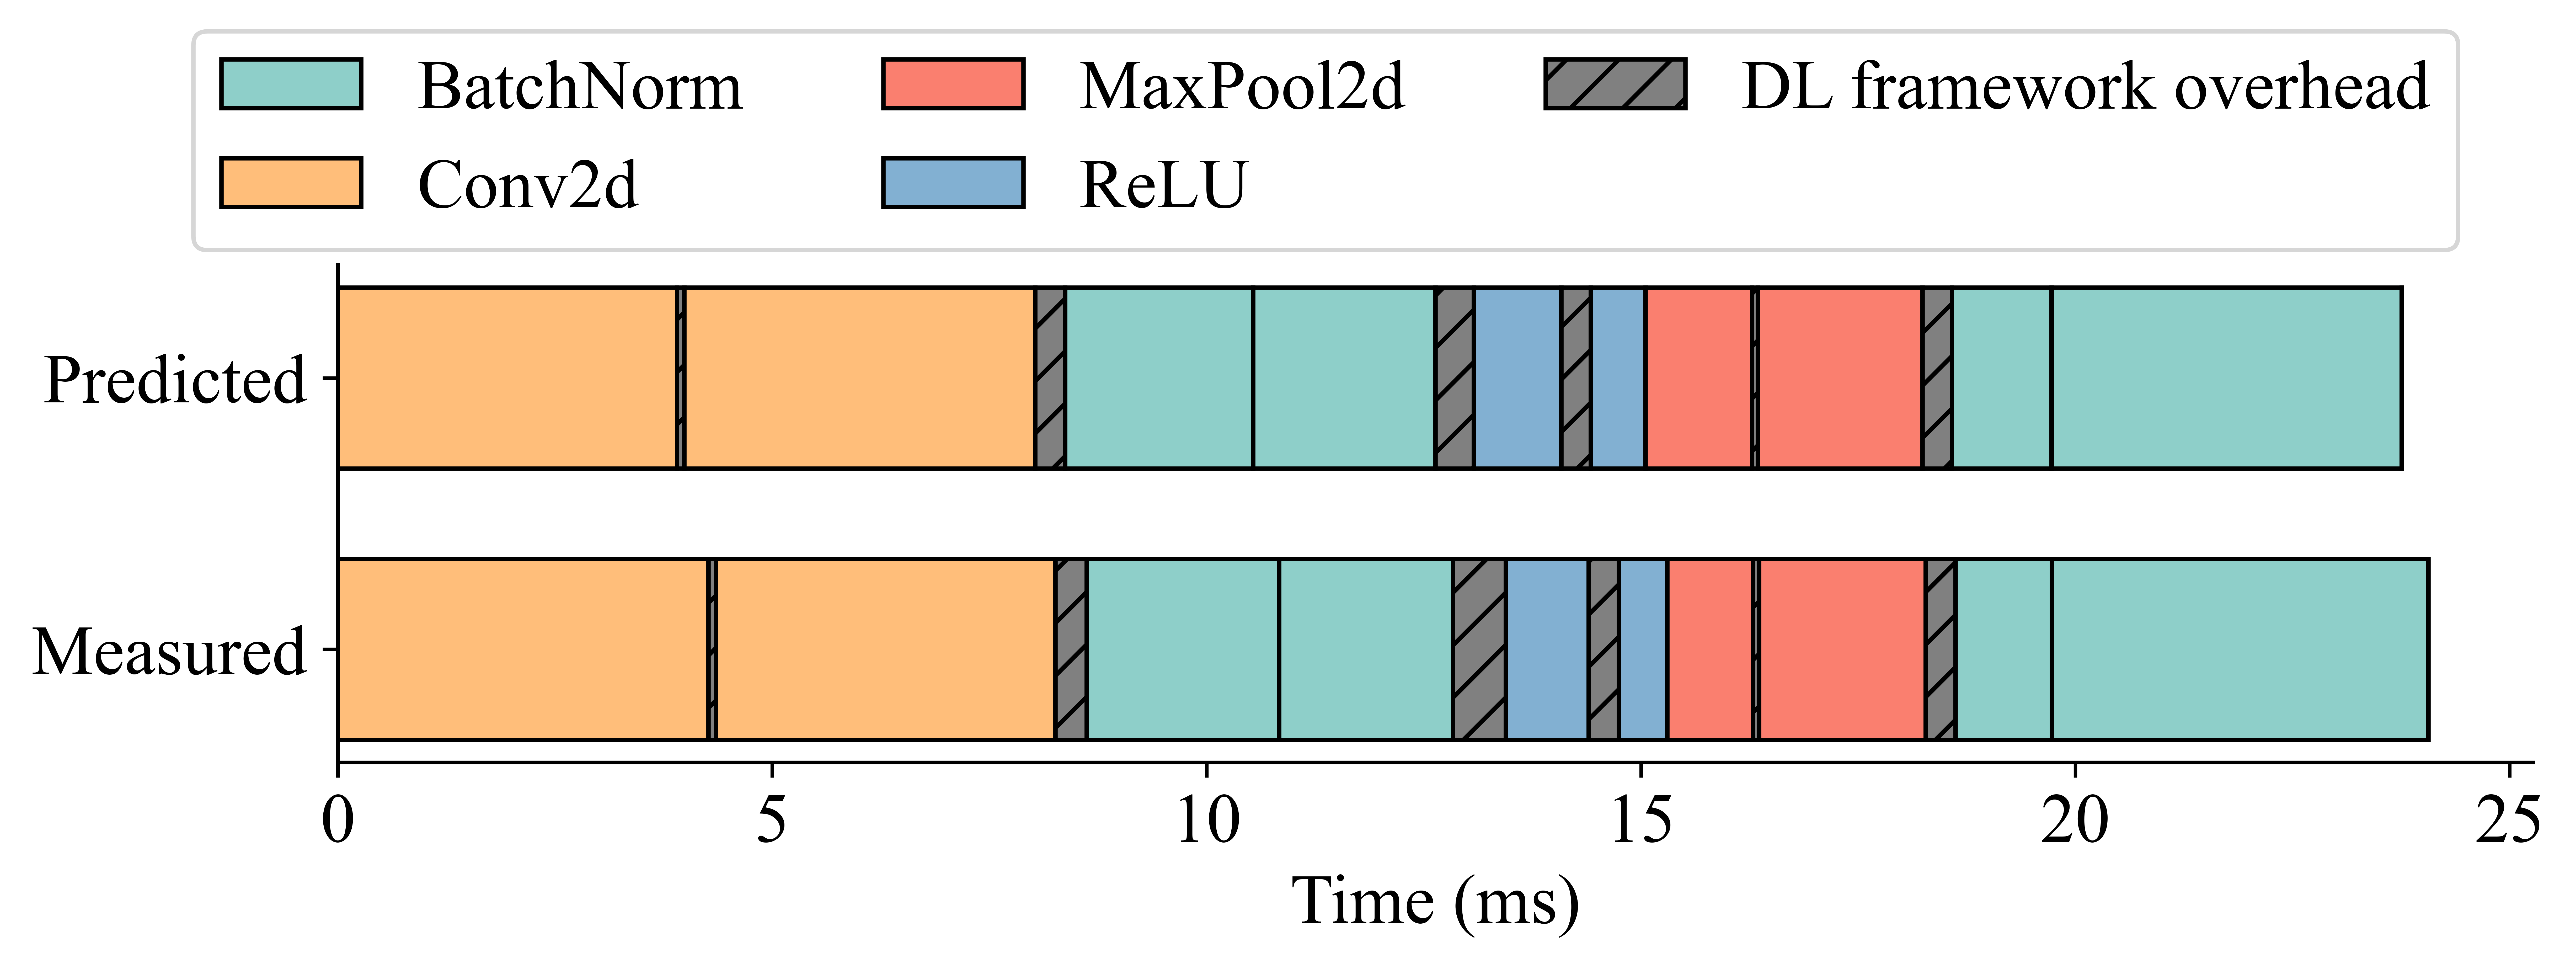

In [17]:
def draw_detail_iteration_time():
    def read_detail_data():
        with open("./plots/model_detail/details.csv", "r") as f:
            lines = f.readlines()
            op_line = lines[0]
            ops = op_line.split(",")
            measured_line = lines[2]
            measured = measured_line.split(",")
            predicted_line = lines[3]
            predicted = predicted_line.split(",")
            ops = [op.strip() for op in ops]
            measured = [float(m.strip()) for m in measured]
            predicted = [float(p.strip()) for p in predicted]
            return ops, measured, predicted

    ops, measured, predicted = read_detail_data()
    op_type_list = sorted(list(set(ops)))
    op_type_to_label = {
        "conv2d": "Conv2d",
        "batchnorm": "BatchNorm",
        "relu": "ReLU",
        "maxpool2d": "MaxPool2d",
    }
    def op_to_color(op): return colors[op_type_list.index(op)]
    overhead_color = "gray"
    print(f"ops: {ops}")
    print(f"measured: {measured}")
    print(f"predicted: {predicted}")
    # plot the stack bar chart
    fig, ax = plt.subplots(figsize=(9, 2), dpi=1200)
    mpl.rcParams['font.family'] = 'Times New Roman'
    original_fontsize = mpl.rcParams["font.size"]
    width = 0.05
    hatch = "//"
    x = range(len(ops))

    def draw_bar(pos, op_durs):
        for i in range(int(len(ops)/2)):
            op = ops[i]
            kernel_dur = op_durs[2*i] / 1e3
            gap_dur = op_durs[2*i+1] / 1e3
            bottom = sum(op_durs[:2*i]) / 1e3
            print(bottom)
            ax.barh(pos, kernel_dur, width, hatch='', left=bottom,
                    color=op_to_color(op), edgecolor='black')
            ax.barh(pos, gap_dur, width, hatch=hatch, left=bottom +
                    kernel_dur, color=overhead_color, edgecolor='black')
    pos = (0, 0.075)
    draw_bar(pos[0], measured)
    draw_bar(pos[1], predicted)
    ax.set_yticks(pos)
    ax.set_yticklabels(["Measured", "Predicted"])
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("")

    legend_artists = []
    for i, op in enumerate(op_type_list):
        handle = Patch(
            facecolor=op_to_color(op),
            edgecolor="black",
            label=op_type_to_label[op],
        )
        legend_artists.append(handle)
    handle = Patch(
        facecolor=overhead_color,
        edgecolor="black",
        label="DL framework overhead",
        hatch=hatch
    )
    legend_artists.append(handle)
    ax.legend(handles=legend_artists, bbox_to_anchor=(
        0.45, 1.25), loc='center', ncol=3, borderaxespad=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.subplots_adjust(top=0.9)
    fig.savefig(f'imgs/detail_iteration_time.pdf', dpi=1200,
                format='pdf', bbox_inches='tight')


draw_detail_iteration_time()

In [24]:
def draw_op_details():
    def read_op_details():
        with open("./plots/op_details.csv", "r") as f:
            # columns op,duration_mre,duration_rmse,gap_mre,gap_rmse,total_mre,total_rmse,total
            csv = pds.read_csv(f)
            return csv

    csv = read_op_details()
    ops = csv["op"].to_list()
    print(ops)
    op_to_label = {
        "conv2d": "Conv2D",
        "batchnorm": "Batch\nNorm2D",
        "relu": "ReLU",
        "max_pool2d": "Max\nPool2D",
        "iadd": "Add",
        "adaptive_avg_pool2d": "Adaptive\nAvg\nPool2D",
        "linear": "Linear",
        "cross_entrpy": "Cross\nEntropy\nLoss",
        "cat": "Concat",
        "avg_pool2d": "Avg\nPool2D",
        "silu": "SiLU",
        "sigmoid": "Sigmoid",
        "floordiv": "FloorDiv",
        "bernoulli": "Bernoulli",
        "hardswish": "Hard\nswish",
        "hardsigmoid": "Hard\nsigmoid",
        "sub": "Sub",
        "mean": "Mean",
        "clone": "Clone",
        "LSTMCell": "LSTM\nCell",
        "RNNCell": "RNN\nCell",
        "GRUCell": "GRU\nCell",
    }

    random.seed(0)

    def fix(val):
        if (val > 0.8):
            val = random.uniform(0.5, 0.8)
        return val

    def op_kernel_mre(op):
        val = csv[csv["op"] == op]["duration_mre"].item()
        return fix(val)

    def op_gap_mre(op):
        val = csv[csv["op"] == op]["gap_mre"].item()
        return fix(val)

    def op_importance(op):
        return csv[csv["op"] == op]["total"].item()
    op_to_importance = {op: op_importance(op) for op in ops}
    # sort ops by importance
    ops = sorted(ops, key=lambda op: op_to_importance[op], reverse=True)
    op_kernel_mres = [op_kernel_mre(op) for op in ops]
    op_gap_mres = [op_gap_mre(op) for op in ops]

    # plot the bar chart, each group has two bars, one for mre, one for rmse. Each op corresponds to a group.
    fig, ax = plt.subplots(figsize=(20, 3), dpi=1200)
    mpl.rcParams.update({'font.size': 16})
    mpl.rcParams['font.family'] = 'Times New Roman'
    width = 0.3

    x = np.arange(len(ops))
    bar1 = ax.bar(x - width/2, op_kernel_mres, width, hatch="",
                  color=colors[0], edgecolor='black', label="Kernel")
    bar2 = ax.bar(x + width/2, op_gap_mres, width, hatch="//",
                  color=colors[1], edgecolor='black', label="DL framework overhead")
    ax.set_xticks(x)
    ax.set_xticklabels([op_to_label[op] for op in ops], rotation=90)

    # ax.set_xlabel("Operation")
    ax.set_ylabel("MRE")
    ax.set_ylim(0, 1)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    # percentage on ax0 ticks
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    op_importances = [op_importance(op) for op in ops]
    # set op_importance text on top position of each group
    # for i, op_importance in enumerate(op_importances):
    #     ax.text(i, 0.5, f"{op_importance:.2f}", ha="center", va="bottom")
    for rect0, rect1, op_importance in zip(bar1, bar2, op_importances):
        height = max(rect0.get_height(), rect1.get_height())
        # x = (rect0.get_x() + rect1.get_x()) / 2.0
        x = rect1.get_x()
        ax.text(x, height, f"{op_importance:.1%}",
                ha="center", va="bottom", fontsize=12)

    # legend
    ax_legend_elements = [
        Patch(facecolor=colors[0], hatch="",
              label='Operator Execution', edgecolor="black"),
        Patch(facecolor=colors[1], hatch="//",
              label='DL framework overhead', edgecolor="black"),
    ]
    ax.legend(handles=ax_legend_elements, bbox_to_anchor=(
        0.45, 1.15), loc='center', ncol=2, borderaxespad=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.subplots_adjust(top=0.9)
    fig.savefig(f'imgs/op_details.pdf', dpi=1200,
                format='pdf', bbox_inches='tight')


draw_op_details()

['conv2d', 'batchnorm', 'relu', 'max_pool2d', 'iadd', 'adaptive_avg_pool2d', 'linear', 'cross_entrpy', 'cat', 'avg_pool2d', 'silu', 'sigmoid', 'floordiv', 'bernoulli', 'hardswish', 'hardsigmoid', 'sub', 'mean', 'clone', 'LSTMCell', 'RNNCell', 'GRUCell']


/tmp/ipykernel_39682/1106920287.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


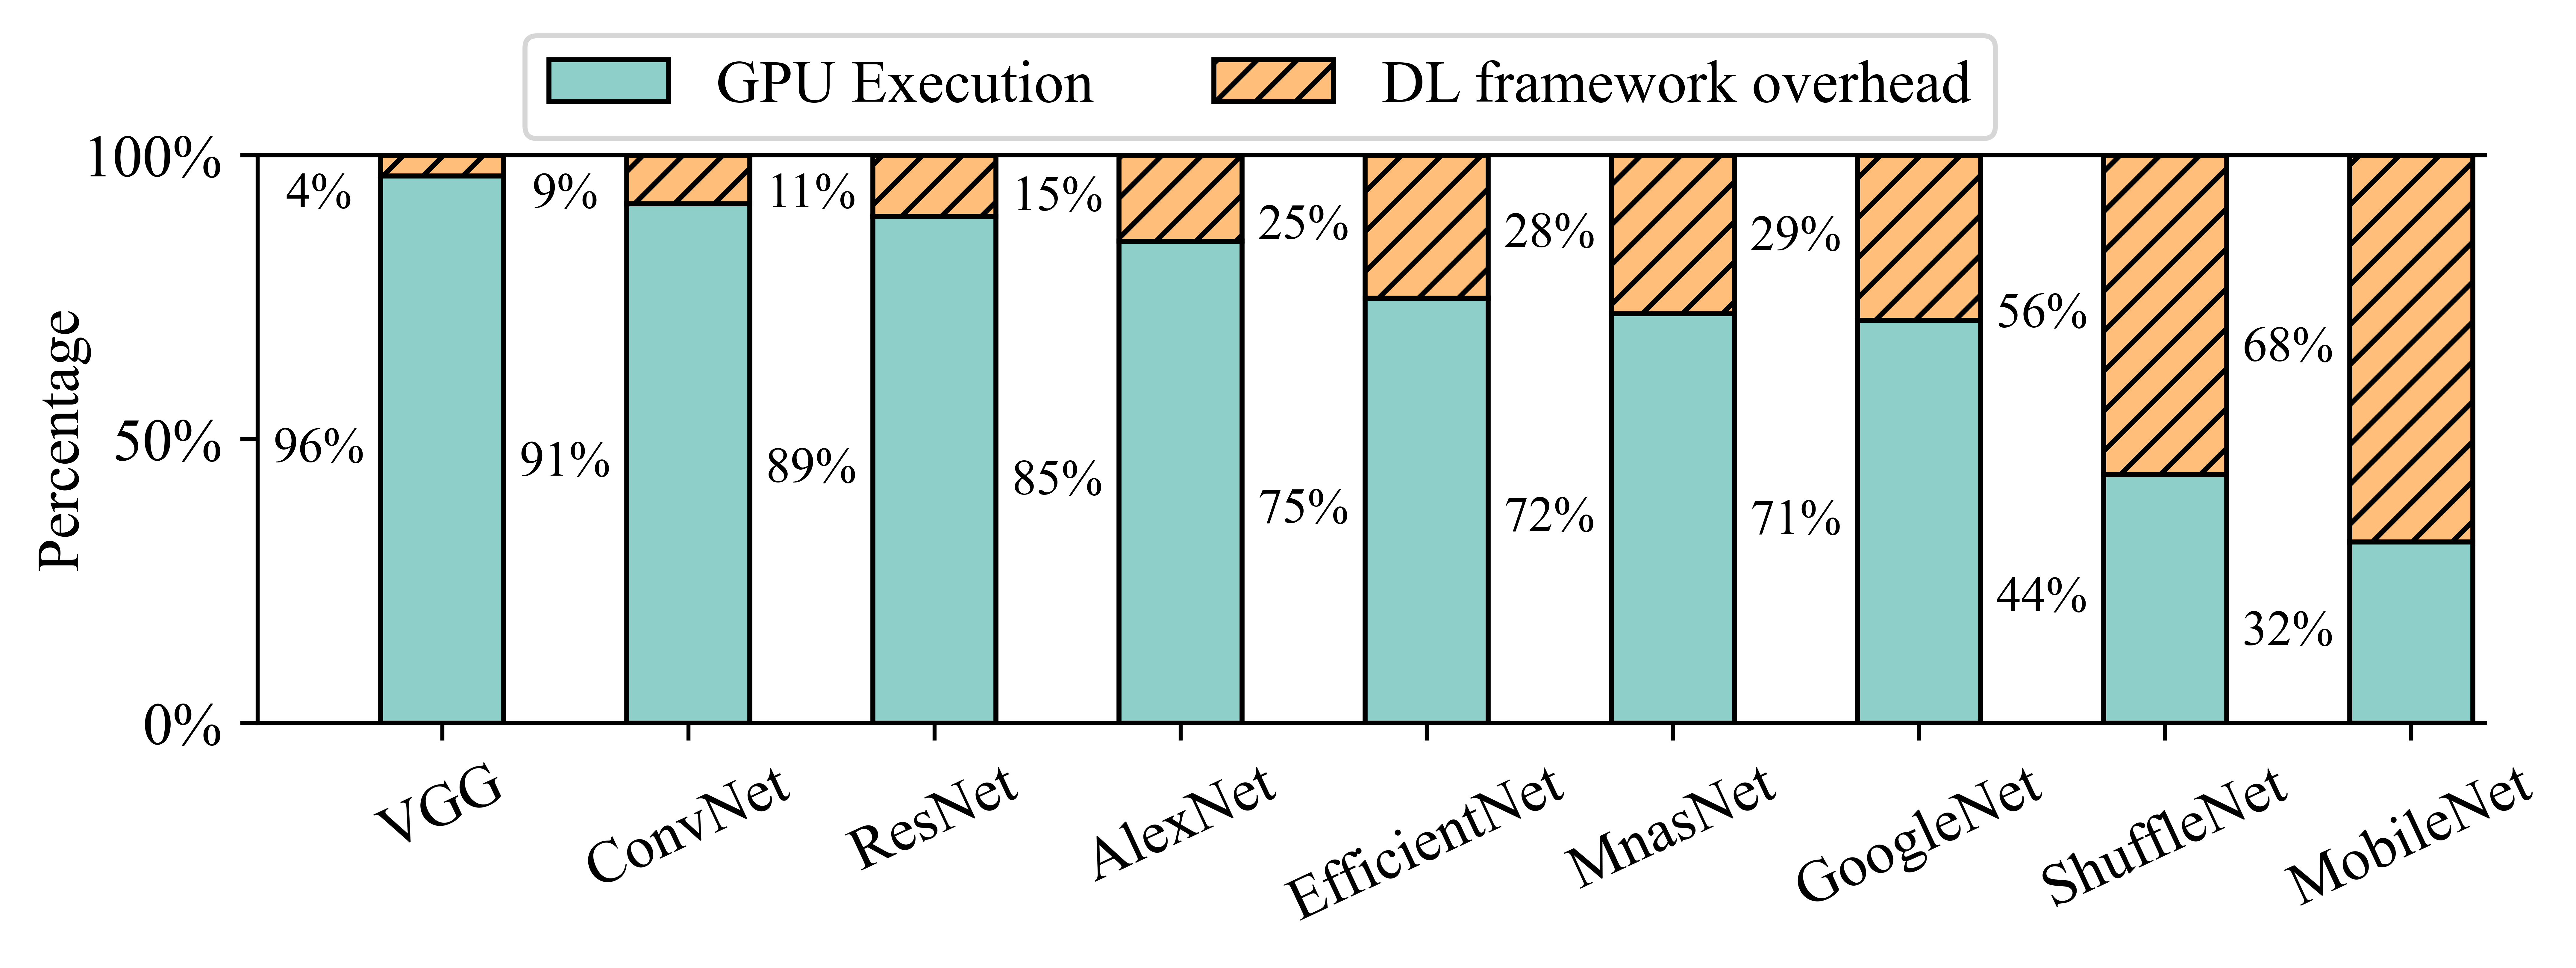

In [19]:
def draw_DL_framework_overhead():
    with open("./plots/DL_framework_overhead.csv", "r") as f:
        csv = pds.read_csv(f)
    models = ["alexnet", "convnext_tiny", "efficientnet_b0", "googlenet",
              "mnasnet0_75", "mobilenet_v3_small", "resnet50", "shufflenet_v2_x1_5", "vgg11_bn"]
    model_to_label = {
        "alexnet": "AlexNet",
        "convnext_tiny": "ConvNet",
        "efficientnet_b0": "EfficientNet",
        "googlenet": "GoogleNet",
        "mnasnet0_75": "MnasNet",
        "mobilenet_v3_small": "MobileNet",
        "resnet50": "ResNet",
        "shufflenet_v2_x1_5": "ShuffleNet",
        "vgg11_bn": "VGG",
    }

    def model_exec_time(model):
        return csv[csv["modelName"] == model]["runningTime"].item()

    def model_framework_overhead(model):
        return csv[csv["modelName"] == model]["spaceTime"].item()
    model_to_exec_time = {model: model_exec_time(model) for model in models}
    model_to_framework_overhead = {
        model: model_framework_overhead(model) for model in models}
    # sort models by percentage of DL framework overhead
    models = sorted(models, key=lambda model: model_to_framework_overhead[model]/(
        model_to_exec_time[model]+model_to_framework_overhead[model]))
    model_exec_times = [model_to_exec_time[model] for model in models]
    model_framework_overheads = [
        model_to_framework_overhead[model] for model in models]

    # Setting up the figure and axes
    plt.rcParams.update({'font.size': 12})
    mpl.rcParams['font.family'] = 'Times New Roman'
    fig, ax = plt.subplots(figsize=(8, 2), dpi=1200)
    hatch = "///"
    width = 0.5

    for i, model_exec_time, model_framework_overhead in zip(range(len(models)), model_exec_times, model_framework_overheads):
        exec_percentage = model_exec_time / \
            (model_exec_time+model_framework_overhead)
        framework_overhead_percentage = model_framework_overhead / \
            (model_exec_time+model_framework_overhead)
        ax.bar(i, exec_percentage,
               color=colors[0], width=width, edgecolor='black')

        def draw_text(x, y, value, ha, va, fontsize):
            if y >= 0.93:
                y = 0.93
            # else:
            #     x += width
            ax.text(x, y, f"{value:.0%}", ha=ha, va=va, fontsize=fontsize)
        draw_text(i - width, exec_percentage/2,
                  exec_percentage, "center", "center", 10)
        ax.bar(i, framework_overhead_percentage, bottom=exec_percentage,
               color=colors[1], width=width, hatch=hatch, edgecolor='black')
        draw_text(i - width, exec_percentage + framework_overhead_percentage /
                  2, framework_overhead_percentage, "center", "center", 10)

    ax.set_xticks(range(len(models)))
    ax.set_xticklabels([model_to_label[model]
                       for model in models], rotation=25)
    ax.set_ylabel("Percentage")
    ax.set_xlim(-0.75, len(models) - 0.7)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.5, 1.0])
    ax.yaxis.set_label_coords(-0.075, 0.5)
    ax.spines['right'].set_visible(False)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    # legend
    ax_legend_elements = [
        Patch(facecolor=colors[0], label='GPU Execution', edgecolor="black"),
        Patch(facecolor=colors[1], hatch=hatch,
              label='DL framework overhead', edgecolor="black"),
    ]
    ax.legend(handles=ax_legend_elements, bbox_to_anchor=(
        0.45, 1.12), loc='center', ncol=2, borderaxespad=0)
    fig.subplots_adjust(top=0.9)
    fig.savefig(f'imgs/DL_framework_overhead.pdf', dpi=1200,
                format='pdf', bbox_inches='tight')


draw_DL_framework_overhead()

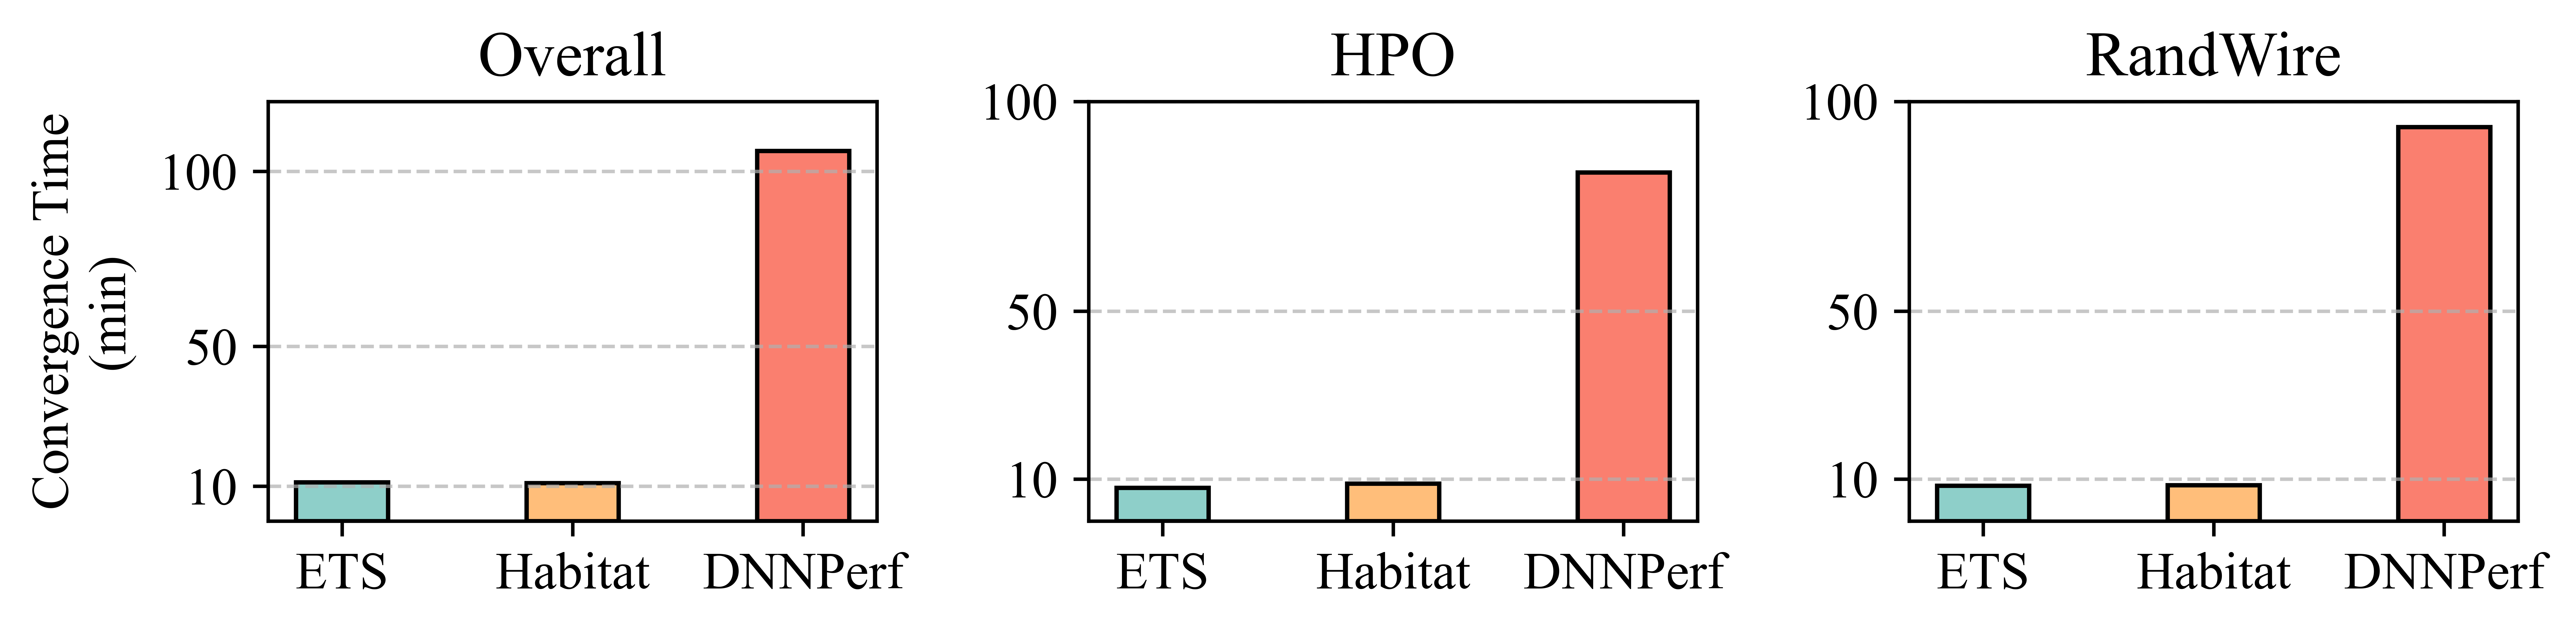

In [20]:
def draw_convergence_time():
    datasets = ["Overall", "HPO", "RandWire"]
    dataset_to_label = {
        "Overall": "Overall",
        "HPO": "HPO",
        "RandWire": "RandWire",
    }
    methods = ["ETS", "Habitat", "DNNPerf"]
    dataset_convergence_time = [
        [11.110951, 10.915015, 105.8819125],  # Overall [ETS, Habitat, DNNPerf]
        [7.981273, 8.97125, 83.0987123],  # HPO [ETS, Habitat, DNNPerf]
        [8.451209, 8.59612, 93.9087555],  # RandWire [ETS, Habitat, DNNPerf]
    ]

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(8, 2), dpi=1200)
    mpl.rcParams.update({'font.size': 12})
    mpl.rcParams['font.family'] = 'Times New Roman'
    fig.tight_layout()
    bar_width = 0.4
    # split models into #group_model_size groups
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        dataset_convergence_times = dataset_convergence_time[i]
        ax.bar(np.arange(len(methods)), dataset_convergence_times,
               width=bar_width, color=colors[:3], hatch="", edgecolor='black')
        ax.set_xticks(np.arange(len(methods)))
        ax.set_xticklabels(methods)
        if (i == 0):
            ax.set_ylabel("Convergence Time\n(min)")
            ax.yaxis.set_label_coords(-0.22, 0.5)
        if (i == 0):
            ax.set_ylim(0, 120)
            ax.set_yticks([10, 50, 100])
        if (i == 1 or i == 2):
            ax.set_ylim(0, 100)
            ax.set_yticks([10, 50, 100])
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_title(f"{dataset_to_label[dataset]}")

    fig.savefig(f'imgs/convergence_time.pdf', dpi=1200,
                format='pdf', bbox_inches='tight')


draw_convergence_time()